In [2]:
import pygmt
import imageio
import xarray as xr
import numpy as np

# Plotting regional variables

Pick up a specific time step:

In [ ]:
step = 0

out = 'export/unconstrained/'
dataset = xr.open_dataset(out+'data'+str(step)+'Ma.nc')

### Elevation

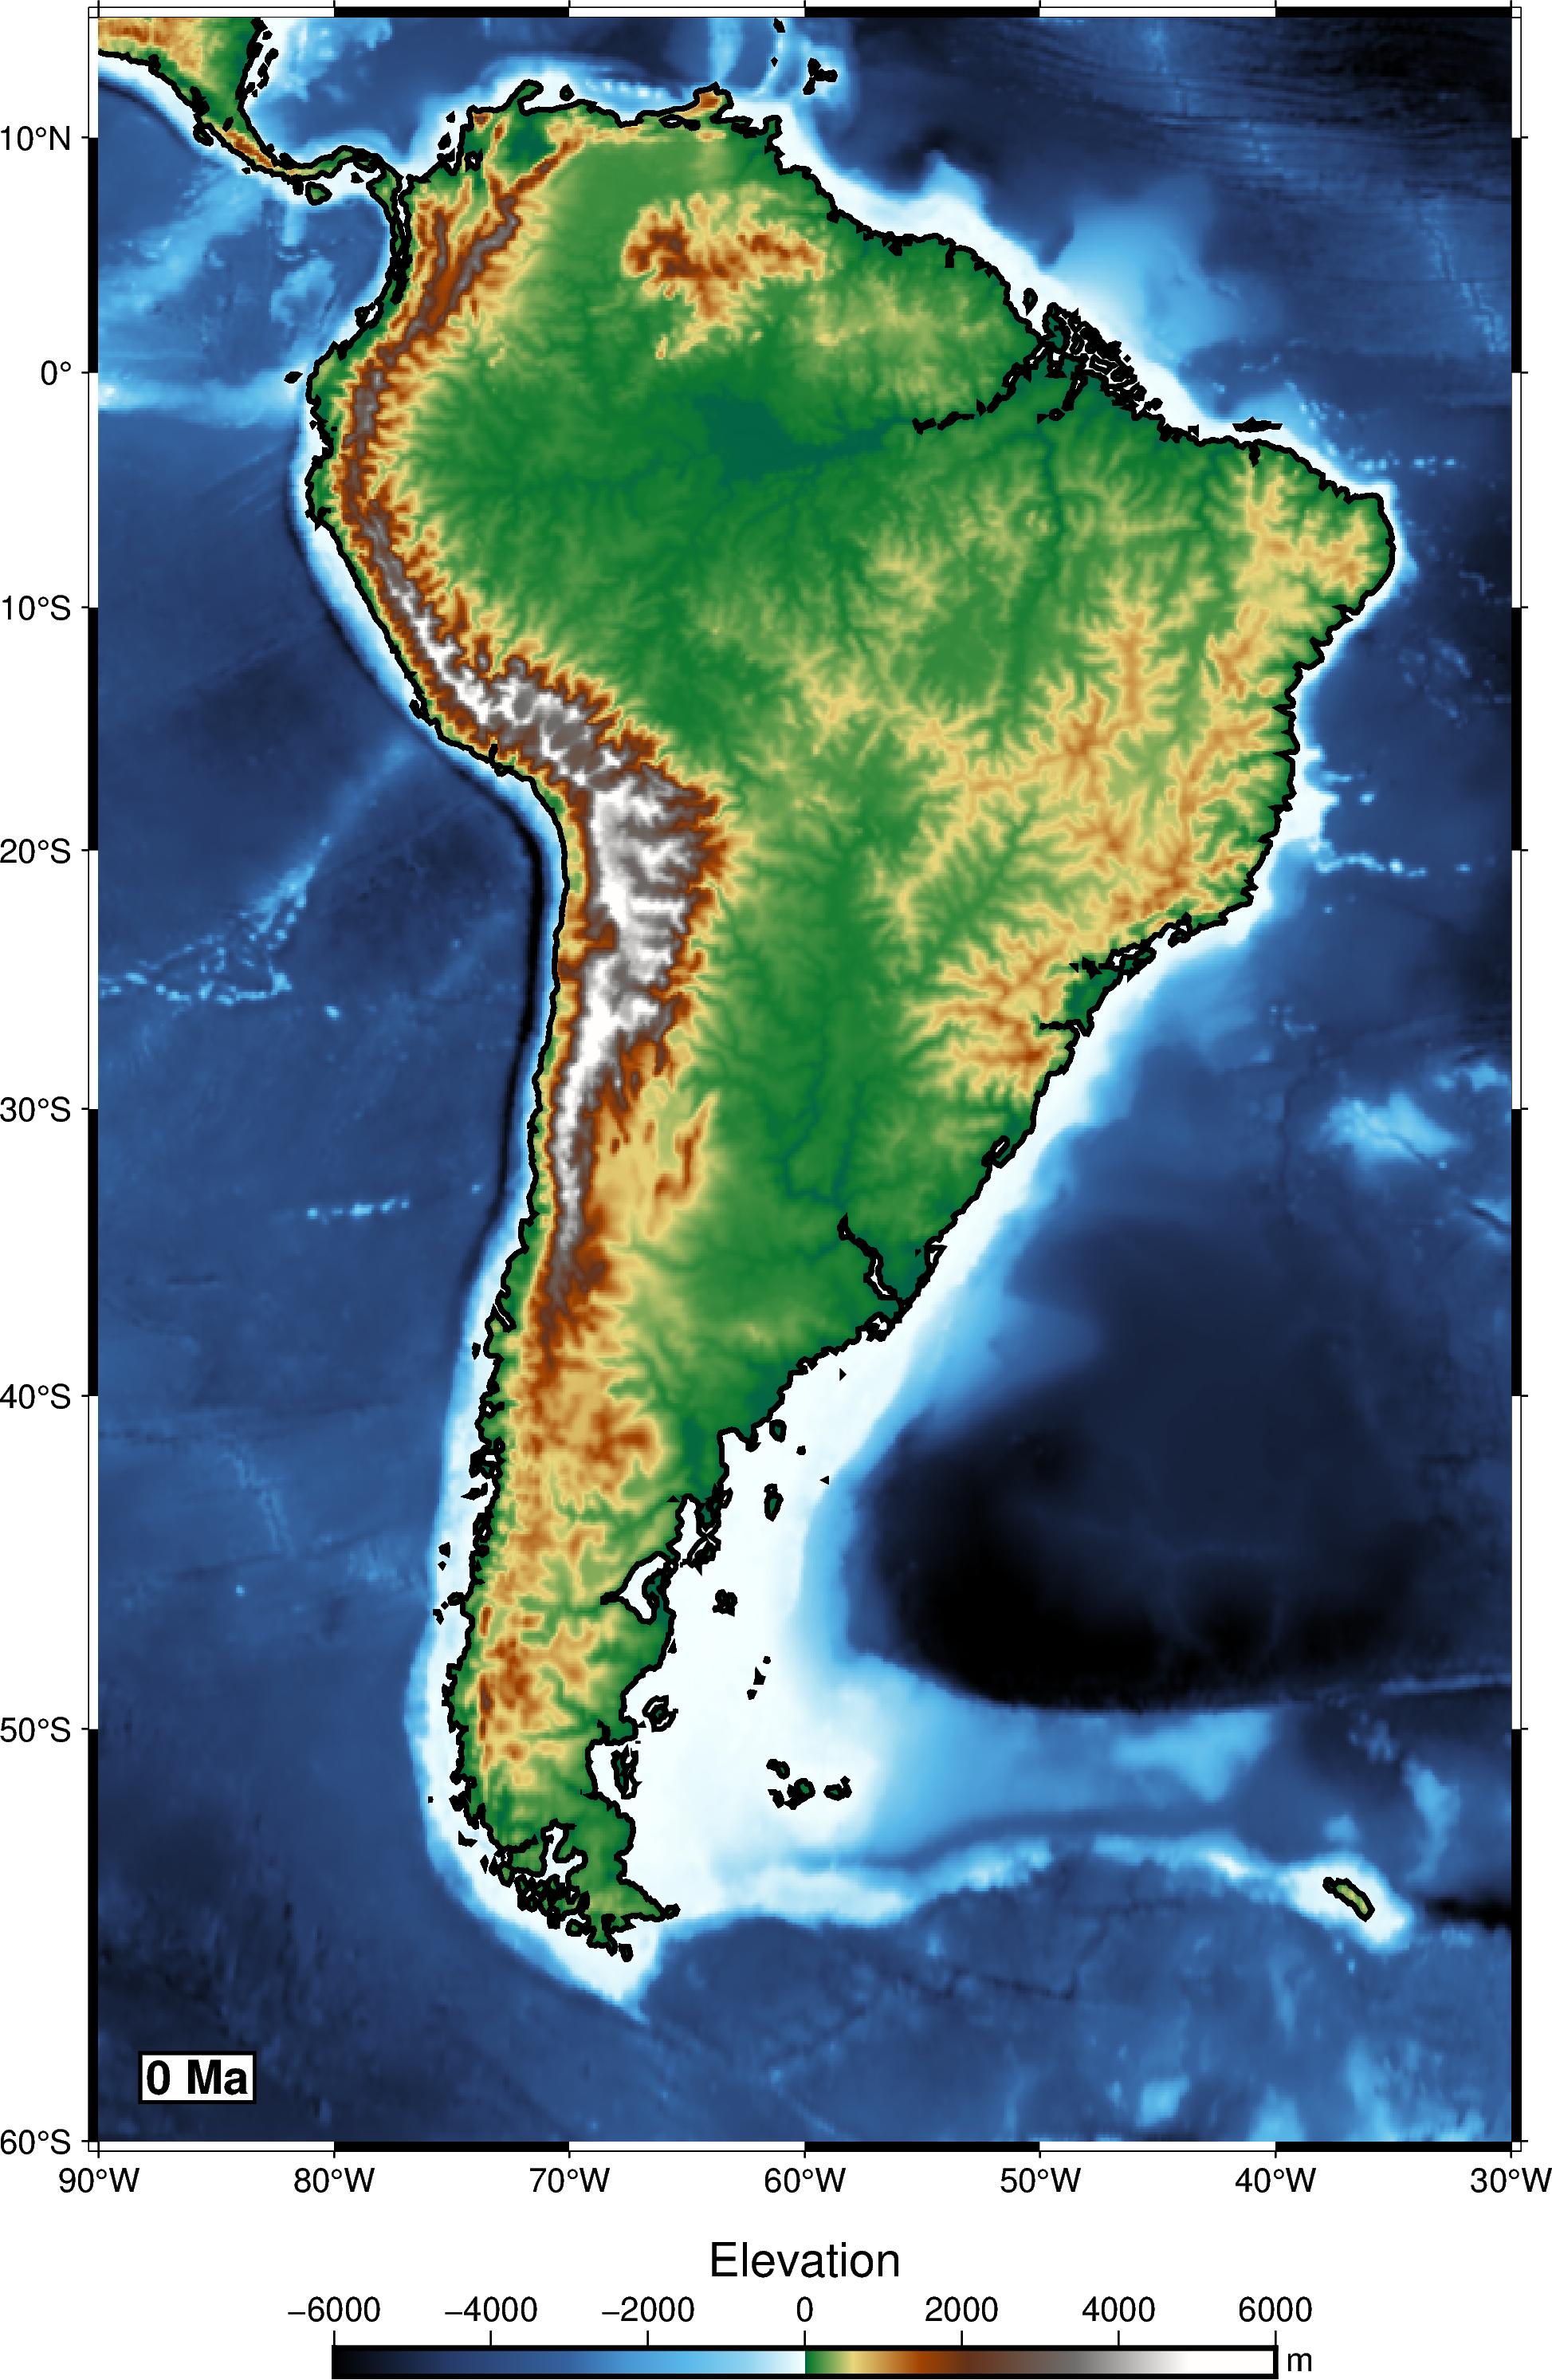

In [3]:
grid = dataset.elevation 

region = [-90,-30,-60,15]

fig = pygmt.Figure()

# Plotting elevation
with pygmt.config(FONT='10p,Helvetica,black'):
    
    pygmt.makecpt(cmap="geo", series=[-6000, 6000])
    
    fig.basemap(region=region, projection='M15c', frame='a')
    
    fig.grdimage(dataset.elevation, 
                 shading=False, 
                 frame=False)
    
    # Add contour
    fig.grdcontour(
        interval=0.1,
        grid=dataset.elevation,
        limit=[-0.1, 0.1],
        pen='1.5p'
    )

fig.colorbar(frame=["a2000", "x+lElevation", "y+lm"], position="jBC+o0c/-2.5c+w10c/0.3c+h") #position="JMR+o0.5c/0c+w8c")

# At time step
fig.text(text=str(step)+" Ma", position="BL", 
         fill='white', pen='1p', offset='0.5',
         font="14p,Helvetica-Bold,black",)

# Save name
# name = 'SAelev'+str(step)+'Ma.png'
# fig.savefig(fname=name,dpi=500)

fig.show()#dpi=500, width=500)

### Erosion/deposition

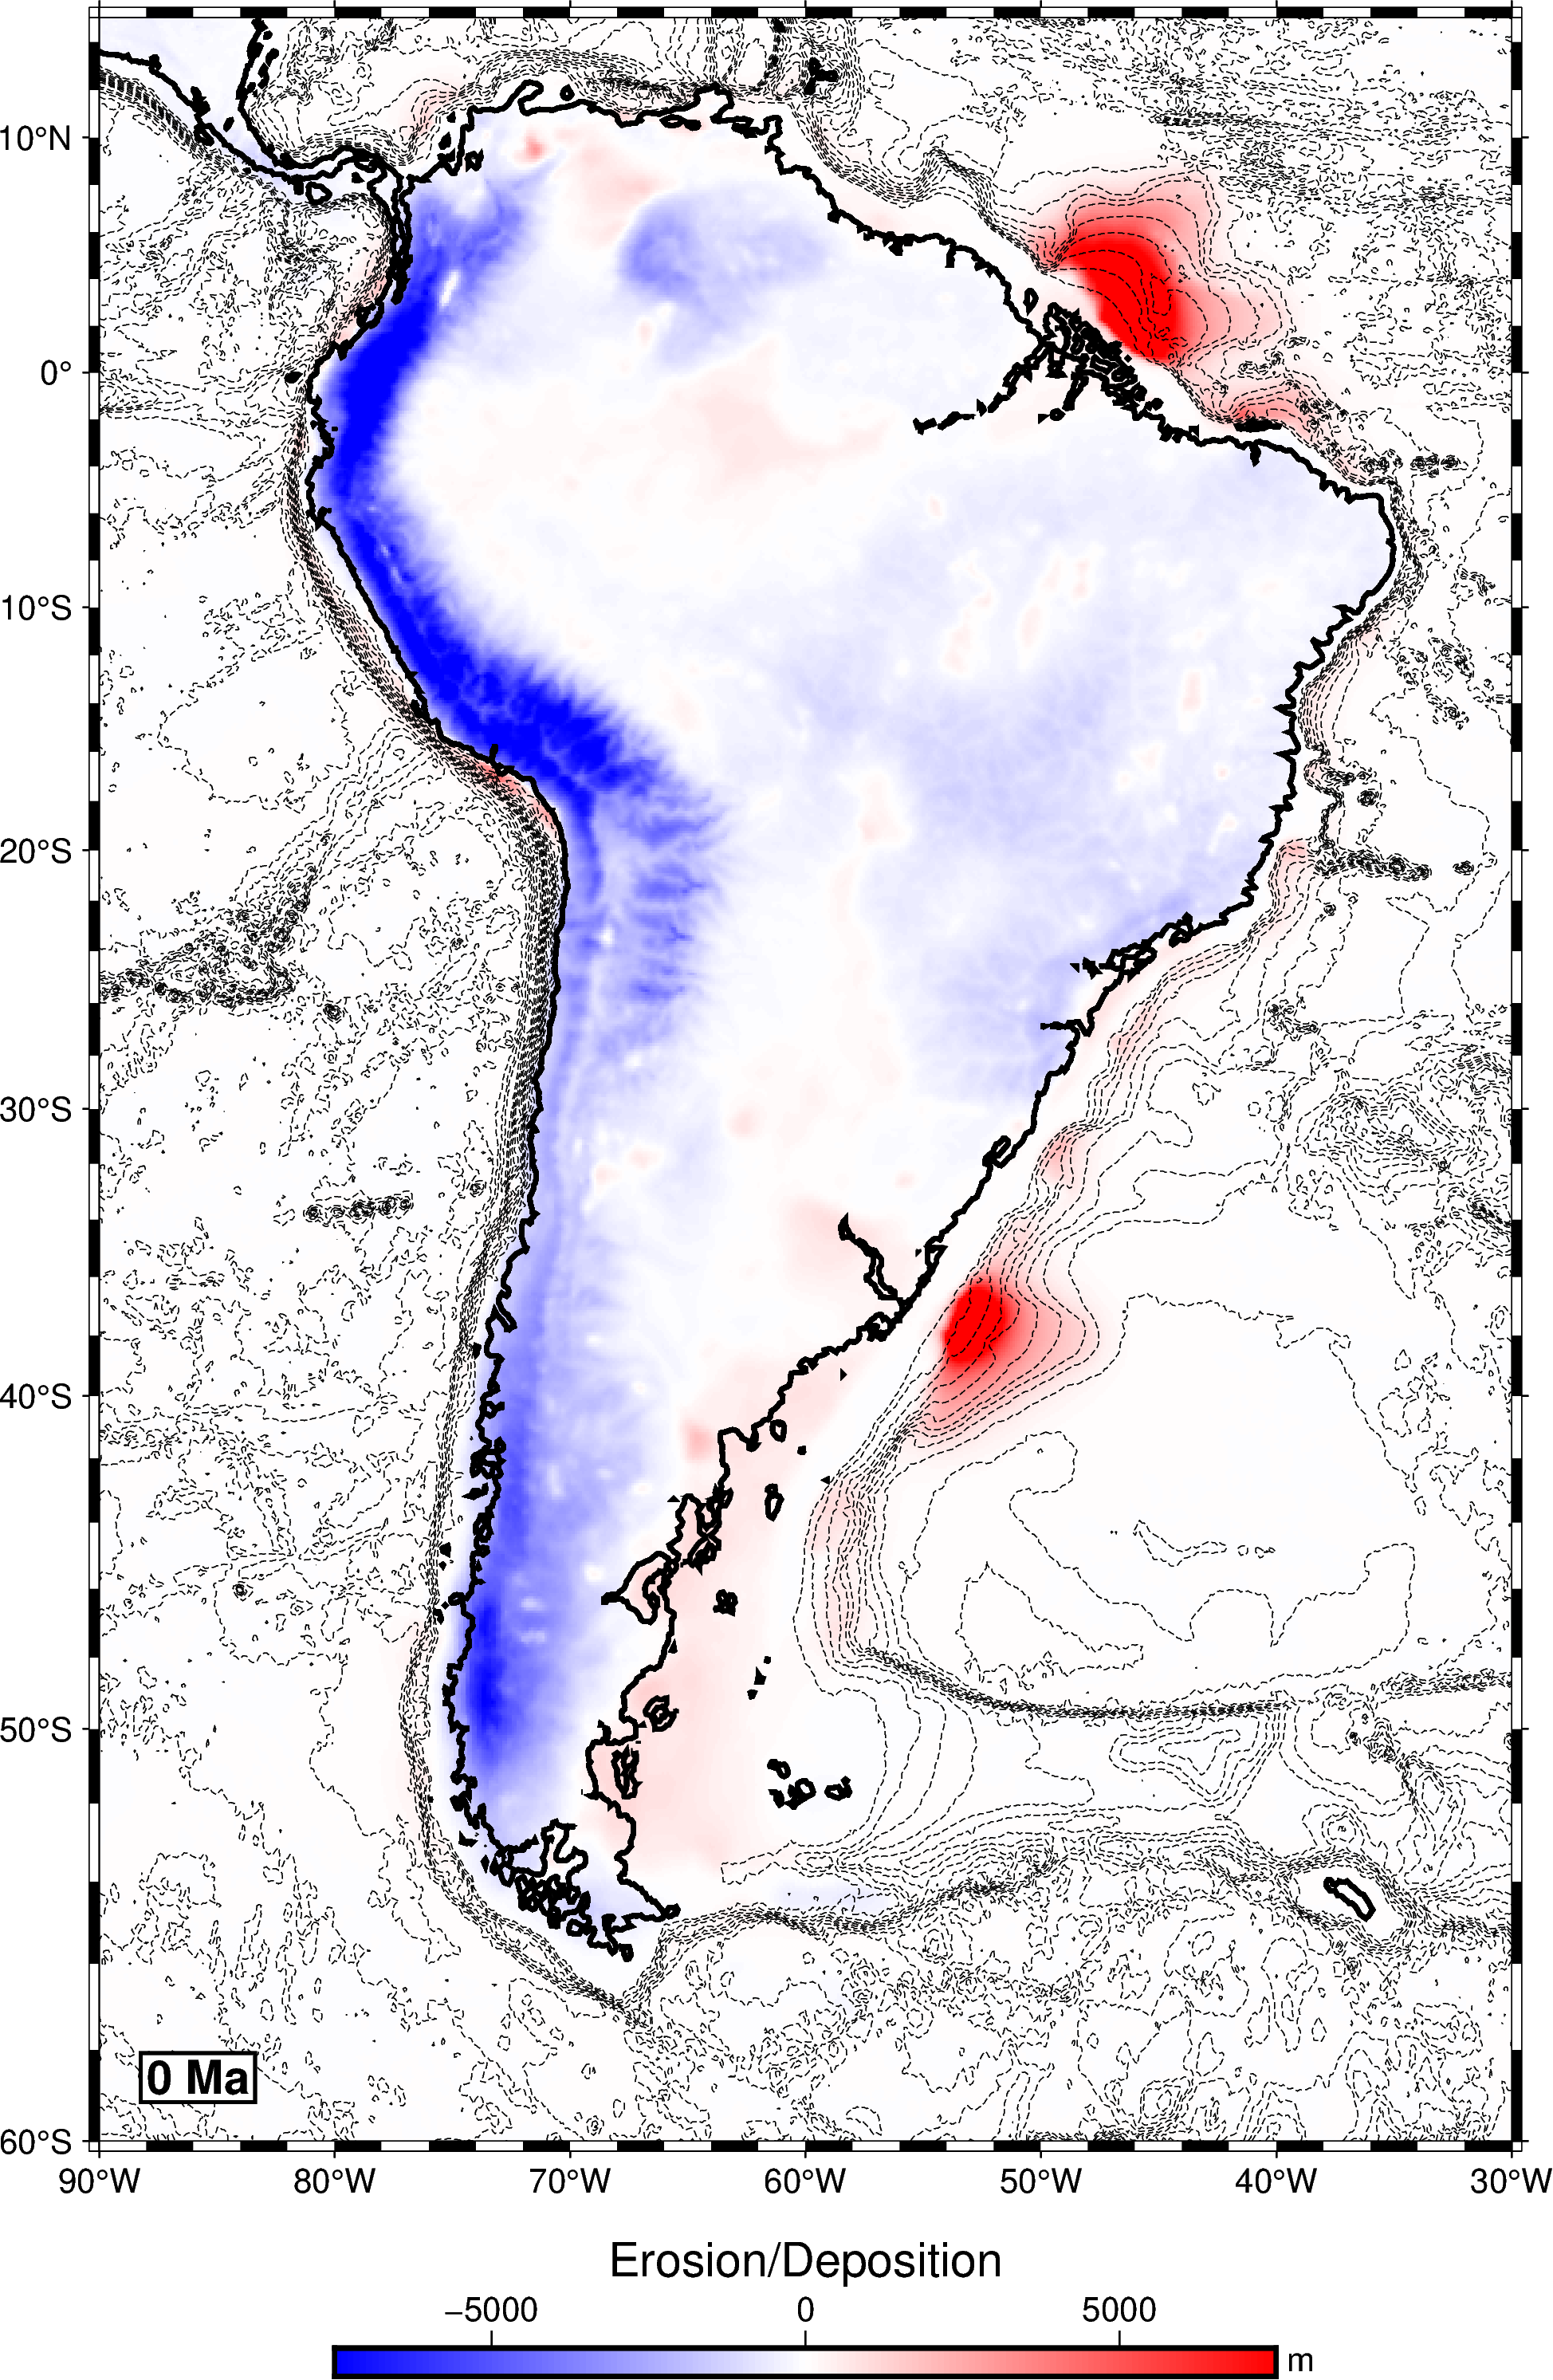

In [4]:
fig = pygmt.Figure()

with pygmt.config(COLOR_FOREGROUND="red", COLOR_BACKGROUND="blue"):
    pygmt.makecpt(
        cmap="polar", 
        series=[-7500,7500, 100],
    )

topo_data = pygmt.grdcut(
    grid,
    region=region,
)

proj='M15c'

fig.grdimage(dataset.erodep, 
             cmap=True,
             region=region,
             projection=proj,
             shading=False,
             frame=True,
            )

# Add contour
fig.grdcontour(
    interval=0.1,
    grid=dataset.elevation,
    region=region,
    projection=proj,
    limit=[-0.1, 0.1],
    pen = '1.5p'
)

# Add contour
fig.grdcontour(
    interval=500,
    grid=dataset.elevation,
    region=region,
    projection=proj,
    limit=[-10000, 0],
    pen = '0.25p,-'
)

fig.colorbar(frame=["a5000", "x+lErosion/Deposition", "y+lm"], position="jBC+o0c/-2.5c+w10c/0.3c+h") #JMR+o0.5c/0c+w8c")

# At time step
fig.text(text=str(step)+" Ma", position="BL", 
         fill='white', pen='1p', offset='0.5',
         font="14p,Helvetica-Bold,black",)

# name = 'SAed'+str(step)+'Ma.png'
# fig.savefig(fname=name,dpi=500)

fig.show()

### Discharge

In [5]:
# We will use a log scale here
vals = np.log10(dataset.fillDischarge)

# Let's look at the maximum log values (we will use it to set our colour bar in the figure below)
vals.max()

<xarray.DataArray 'fillDischarge' ()>
array(13.38423306)

grdimage [WARNING]: Longitude range too small; geographic boundary condition changed to natural.


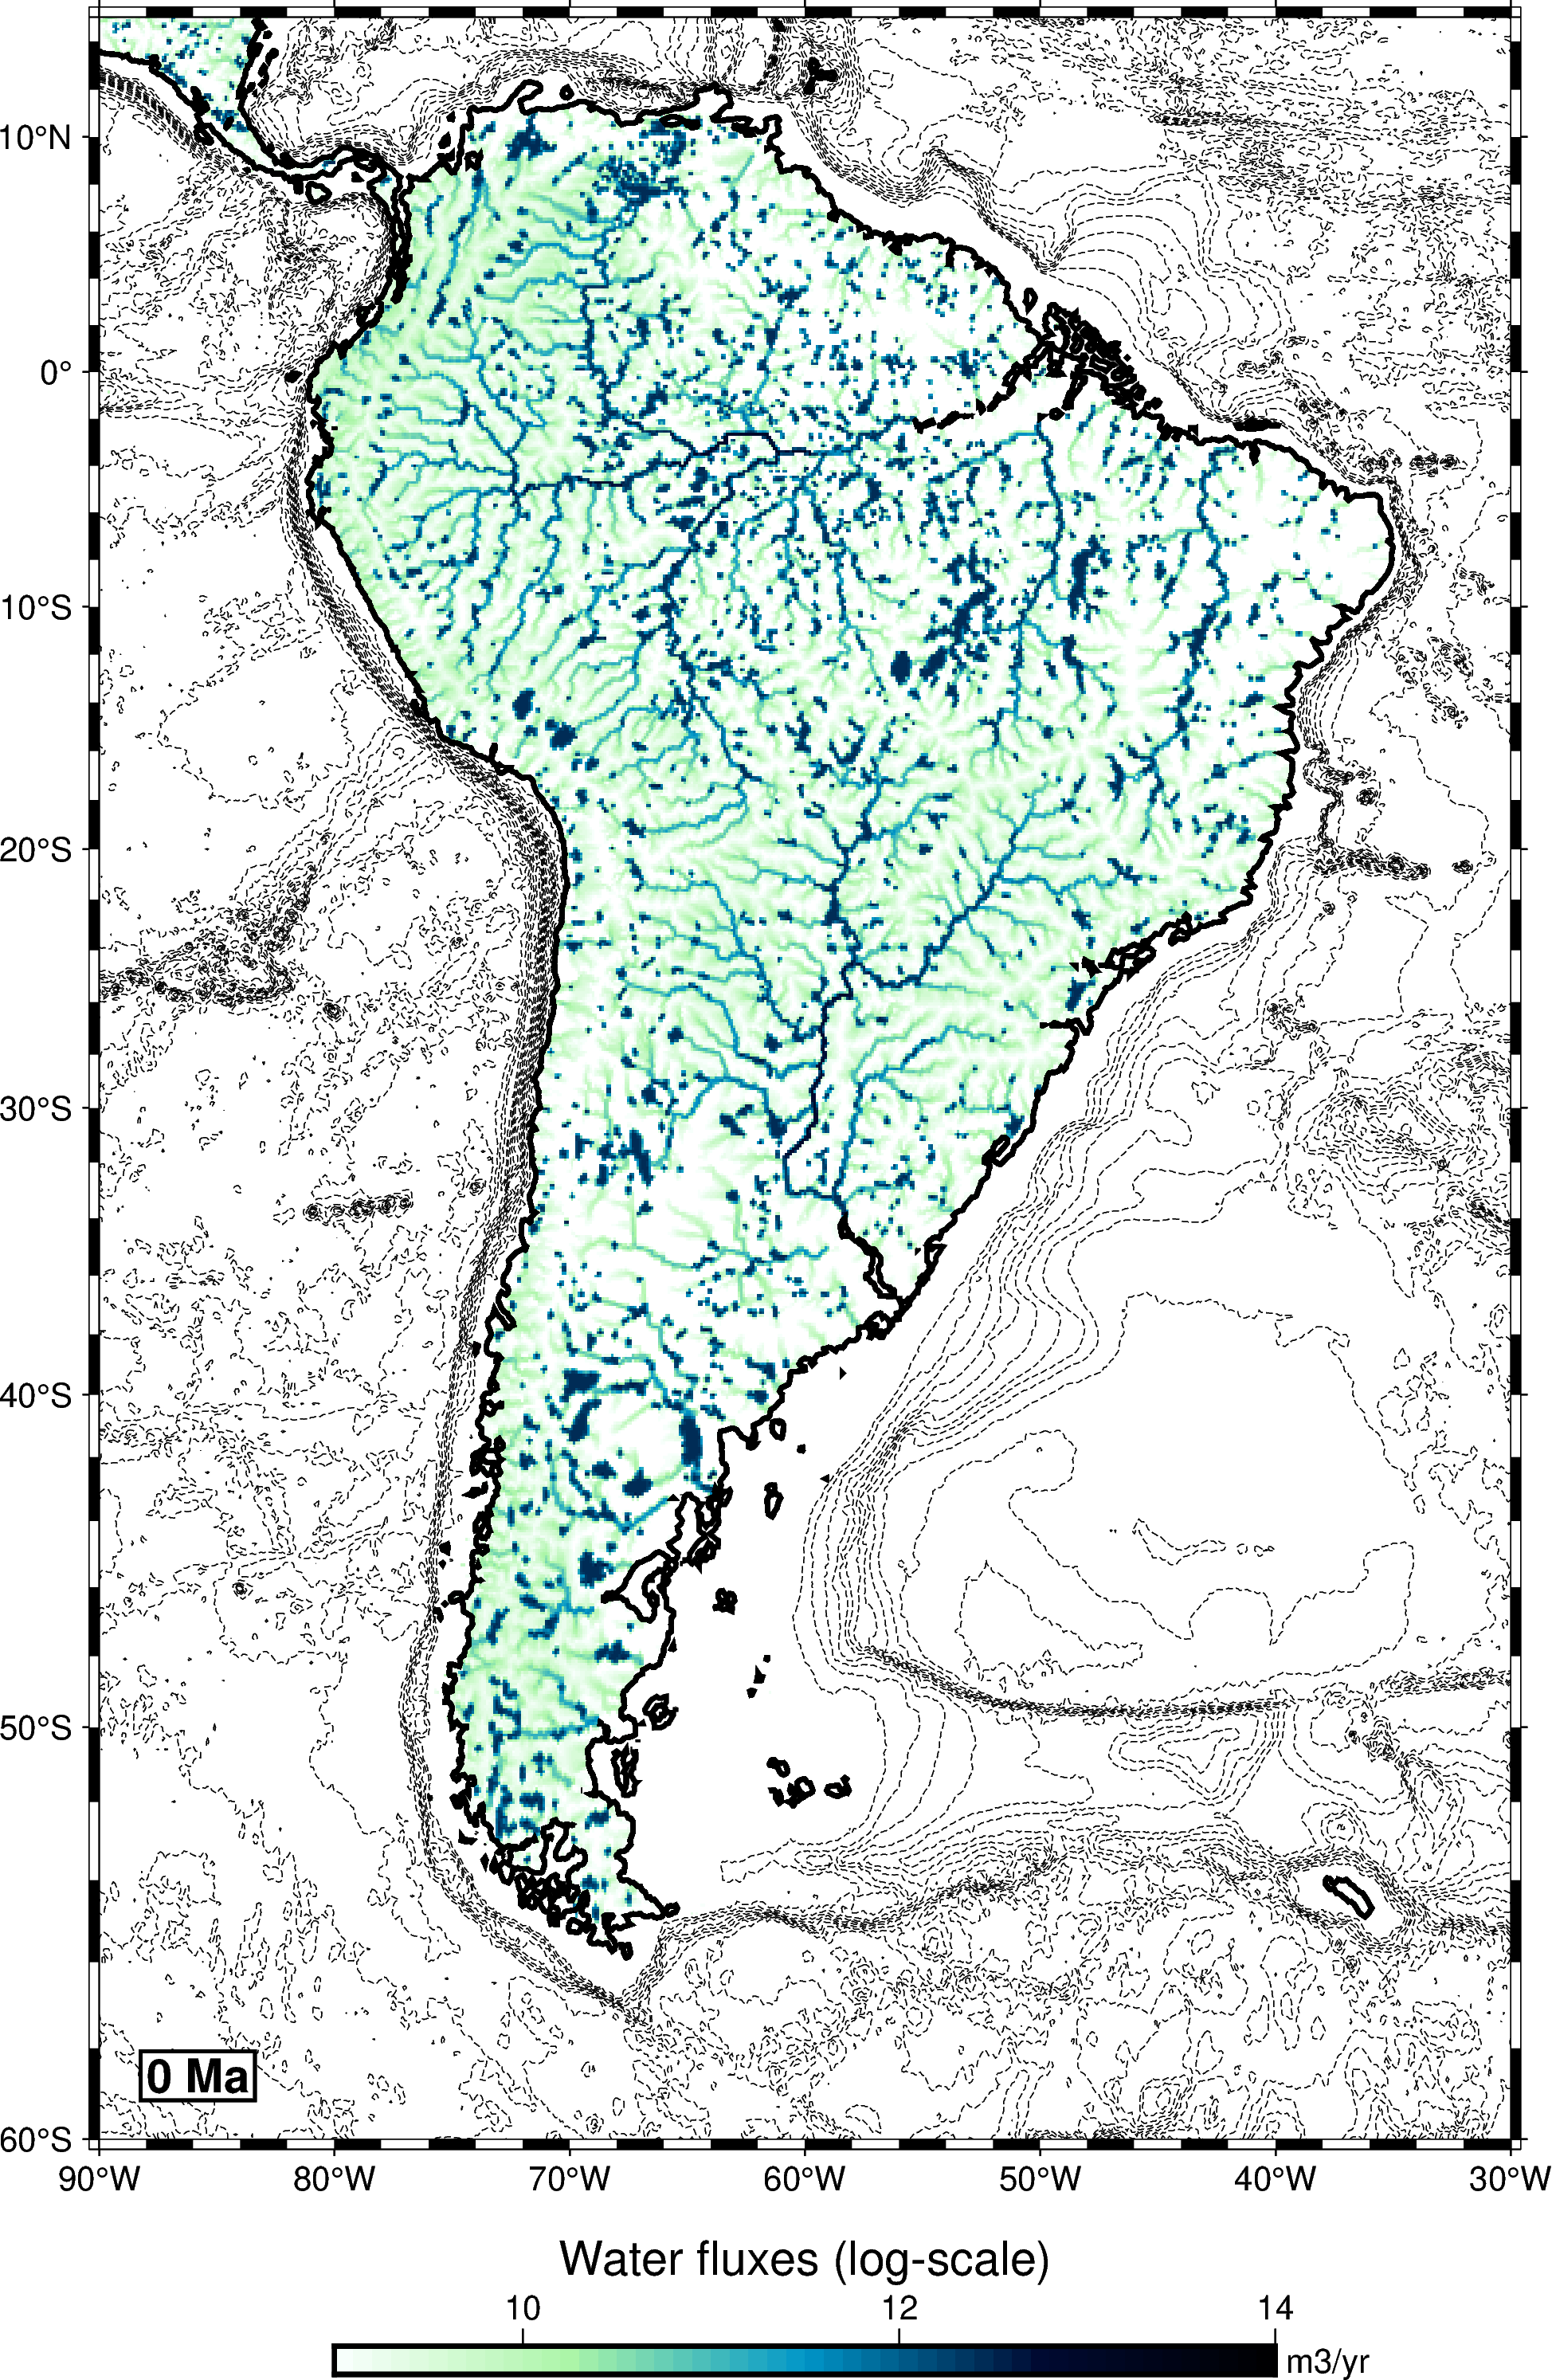

In [6]:
fig = pygmt.Figure()

with pygmt.config(COLOR_BACKGROUND="white"):
    pygmt.makecpt(
        cmap="ocean",
        series=[9,14,0.1],
        reverse=True,
    )

proj='M15c'

fig.grdimage(grid=vals, 
             cmap=True,
             region=region,
             projection=proj,
             shading=False,
             frame=True,
            )

# Add contour
fig.grdcontour(
    interval=0.1,
    grid=dataset.elevation,
    region=region,
    projection=proj,
    limit=[-0.1, 0.1],
    pen = '1.5p'
)

# Add contour
fig.grdcontour(
    interval=500,
    grid=dataset.elevation,
    region=region,
    projection=proj,
    limit=[-10000, 0],
    pen = '0.25p,-'
)

fig.colorbar(frame=["a2", 'x+l"Water fluxes (log-scale)"', "y+lm3/yr"], position="jBC+o0c/-2.5c+w10c/0.3c+h") #JMR+o0.5c/0c+w8c")

# At time step
fig.text(text=str(step)+" Ma", position="BL", 
         fill='white', pen='1p', offset='0.5',
         font="14p,Helvetica-Bold,black",)

# name = 'SAfa'+str(step)+'Ma.png'
# fig.savefig(fname=name,dpi=500)

fig.show()

### Basins

Clip the global dataset to the regional extent

In [7]:
mask_lon = (dataset.longitude >= region[0]) & (dataset.longitude <= region[1])
mask_lat = (dataset.latitude >= region[2]) & (dataset.latitude <= region[3])
clipds = dataset.where(mask_lon & mask_lat, drop=True)

Extract the number of unique basin indices in the clipped dataset

In [8]:
localbasins = clipds.basinID.values.astype(int)
uids = np.unique(localbasins)
localBasinNb = len(uids)
nids = np.arange(len(uids))

Replace basin indices with rearranged incremental indices for the region

In [9]:
mapIDs = np.zeros(localbasins.max()+1, dtype=int) 
mapIDs[uids] = nids
basinIDs = mapIDs[localbasins.flatten()].reshape(localbasins.shape)

In [10]:
dsBasin = xr.DataArray(
    data=basinIDs.astype(float),
    dims=["latitude", "longitude"],
    coords={
        "lat": clipds.latitude,
        "lon": clipds.longitude,
    },
)
ds_masked = dsBasin.where(dsBasin != 0.) 
clipds["newBasin"]=(['latitude', 'longitude'],  ds_masked.values)

In [11]:
localBasinNb

4179

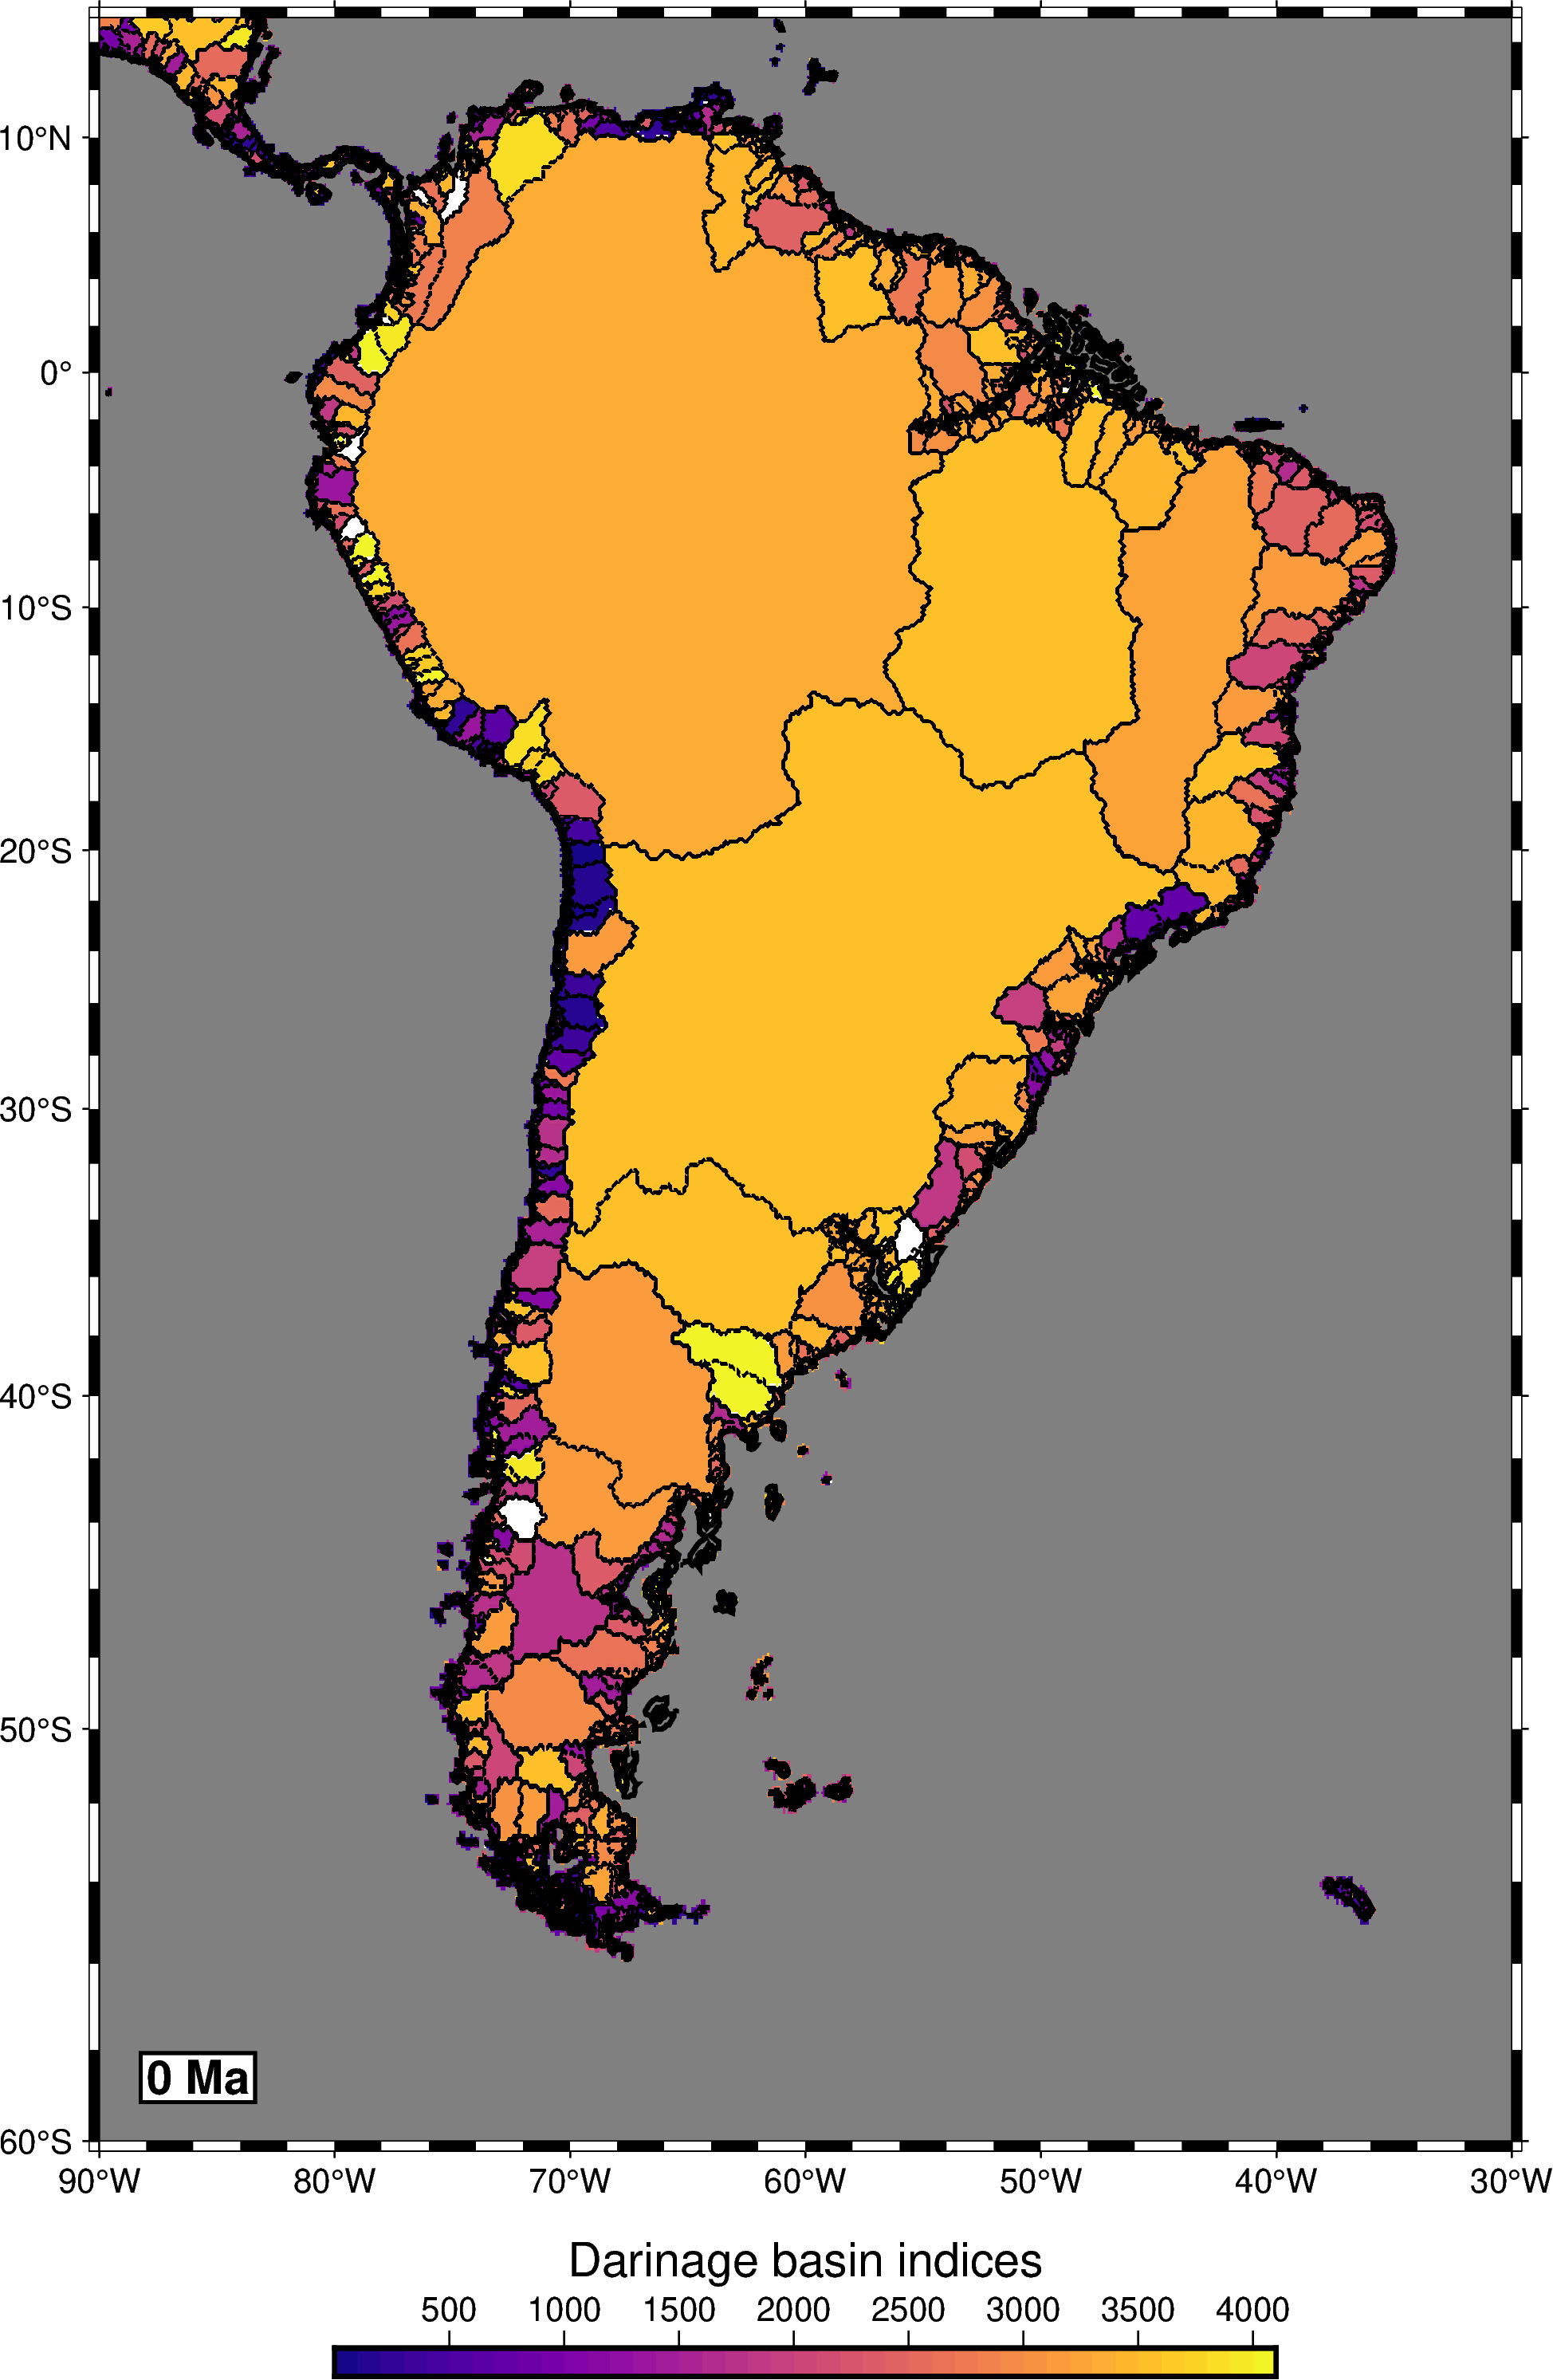

In [12]:
fig = pygmt.Figure()

with pygmt.config(COLOR_FOREGROUND="white", COLOR_BACKGROUND="white"):
    pygmt.makecpt(
        cmap="plasma", 
        series=[1,localBasinNb, 100],
    )
    
proj='M15c'



fig.grdimage(grid=clipds.newBasin,
             cmap=True,
             projection=proj,
             shading=False,
             frame=True,
            )

# Add contour
fig.grdcontour(
    interval=0.1,
    grid=clipds.elevation,
    projection=proj,
    limit=[-0.1, 0.1],
    pen = '1.5p'
)

# Add contour
fig.grdcontour(
    interval=1,
    grid=clipds.newBasin,
    region=region,
    projection=proj,
    limit=[0, 5000],
    pen = '0.25p,-'
)

fig.colorbar(frame=["a500", 'x+l"Darinage basin indices"'], position="jBC+o0c/-2.5c+w10c/0.3c+h") #JMR+o0.5c/0c+w8c")

# At time step
fig.text(text=str(step)+" Ma", position="BL", 
         fill='white', pen='1p', offset='0.5',
         font="14p,Helvetica-Bold,black",)

# name = 'SAbasin'+str(step)+'Ma.png'
# fig.savefig(fname=name,dpi=500)

fig.show()

## Focusing on a single catchment

In [4]:
step = 0

out = 'export/unconstrained/'
dataset = xr.open_dataset(out+'data'+str(step)+'Ma.nc')
region = [-72,-42,-40,-12]

Remove region outside the catchment:

In [5]:
mask_lon = (dataset.longitude >= region[0]) & (dataset.longitude <= region[1])
mask_lat = (dataset.latitude >= region[2]) & (dataset.latitude <= region[3])
clipds = dataset.where(mask_lon & mask_lat, drop=True)

Find unique basin indices

In [6]:
localbasins = clipds.basinID.values.astype(int)
uids = np.unique(localbasins)
localBasinNb = len(uids)
nids = np.arange(len(uids))

Redefine basin indices in the region by ascending values starting at 0:

In [7]:
mapIDs = np.zeros(localbasins.max()+1, dtype=int) 
mapIDs[uids] = nids
basinIDs = mapIDs[localbasins.flatten()].reshape(localbasins.shape)

Let's save the rearranged basin IDs in a new xarray dataframe

In [8]:
dsBasin = xr.DataArray(
    data=basinIDs.astype(float),
    dims=["latitude", "longitude"],
    coords={
        "lat": clipds.latitude,
        "lon": clipds.longitude,
    },
)
ds_masked = dsBasin.where(dsBasin != 0.) 
clipds["newBasin"]=(['latitude', 'longitude'],  ds_masked.values)
print(localBasinNb)

689


Now let's find the catchment ID corresponding to a specific coordinate:

In [12]:
nearest_point = clipds.sel(latitude=-25, longitude=-60, method="nearest")
nearest_point.newBasin.values

array(582.)

We now extract the basin coordinates:

In [13]:
clipds2 = clipds.where(clipds.newBasin==nearest_point.newBasin.values)

### Plotting a single basin

We can then plot a map highlighting the chosen basin.

#### Elevation

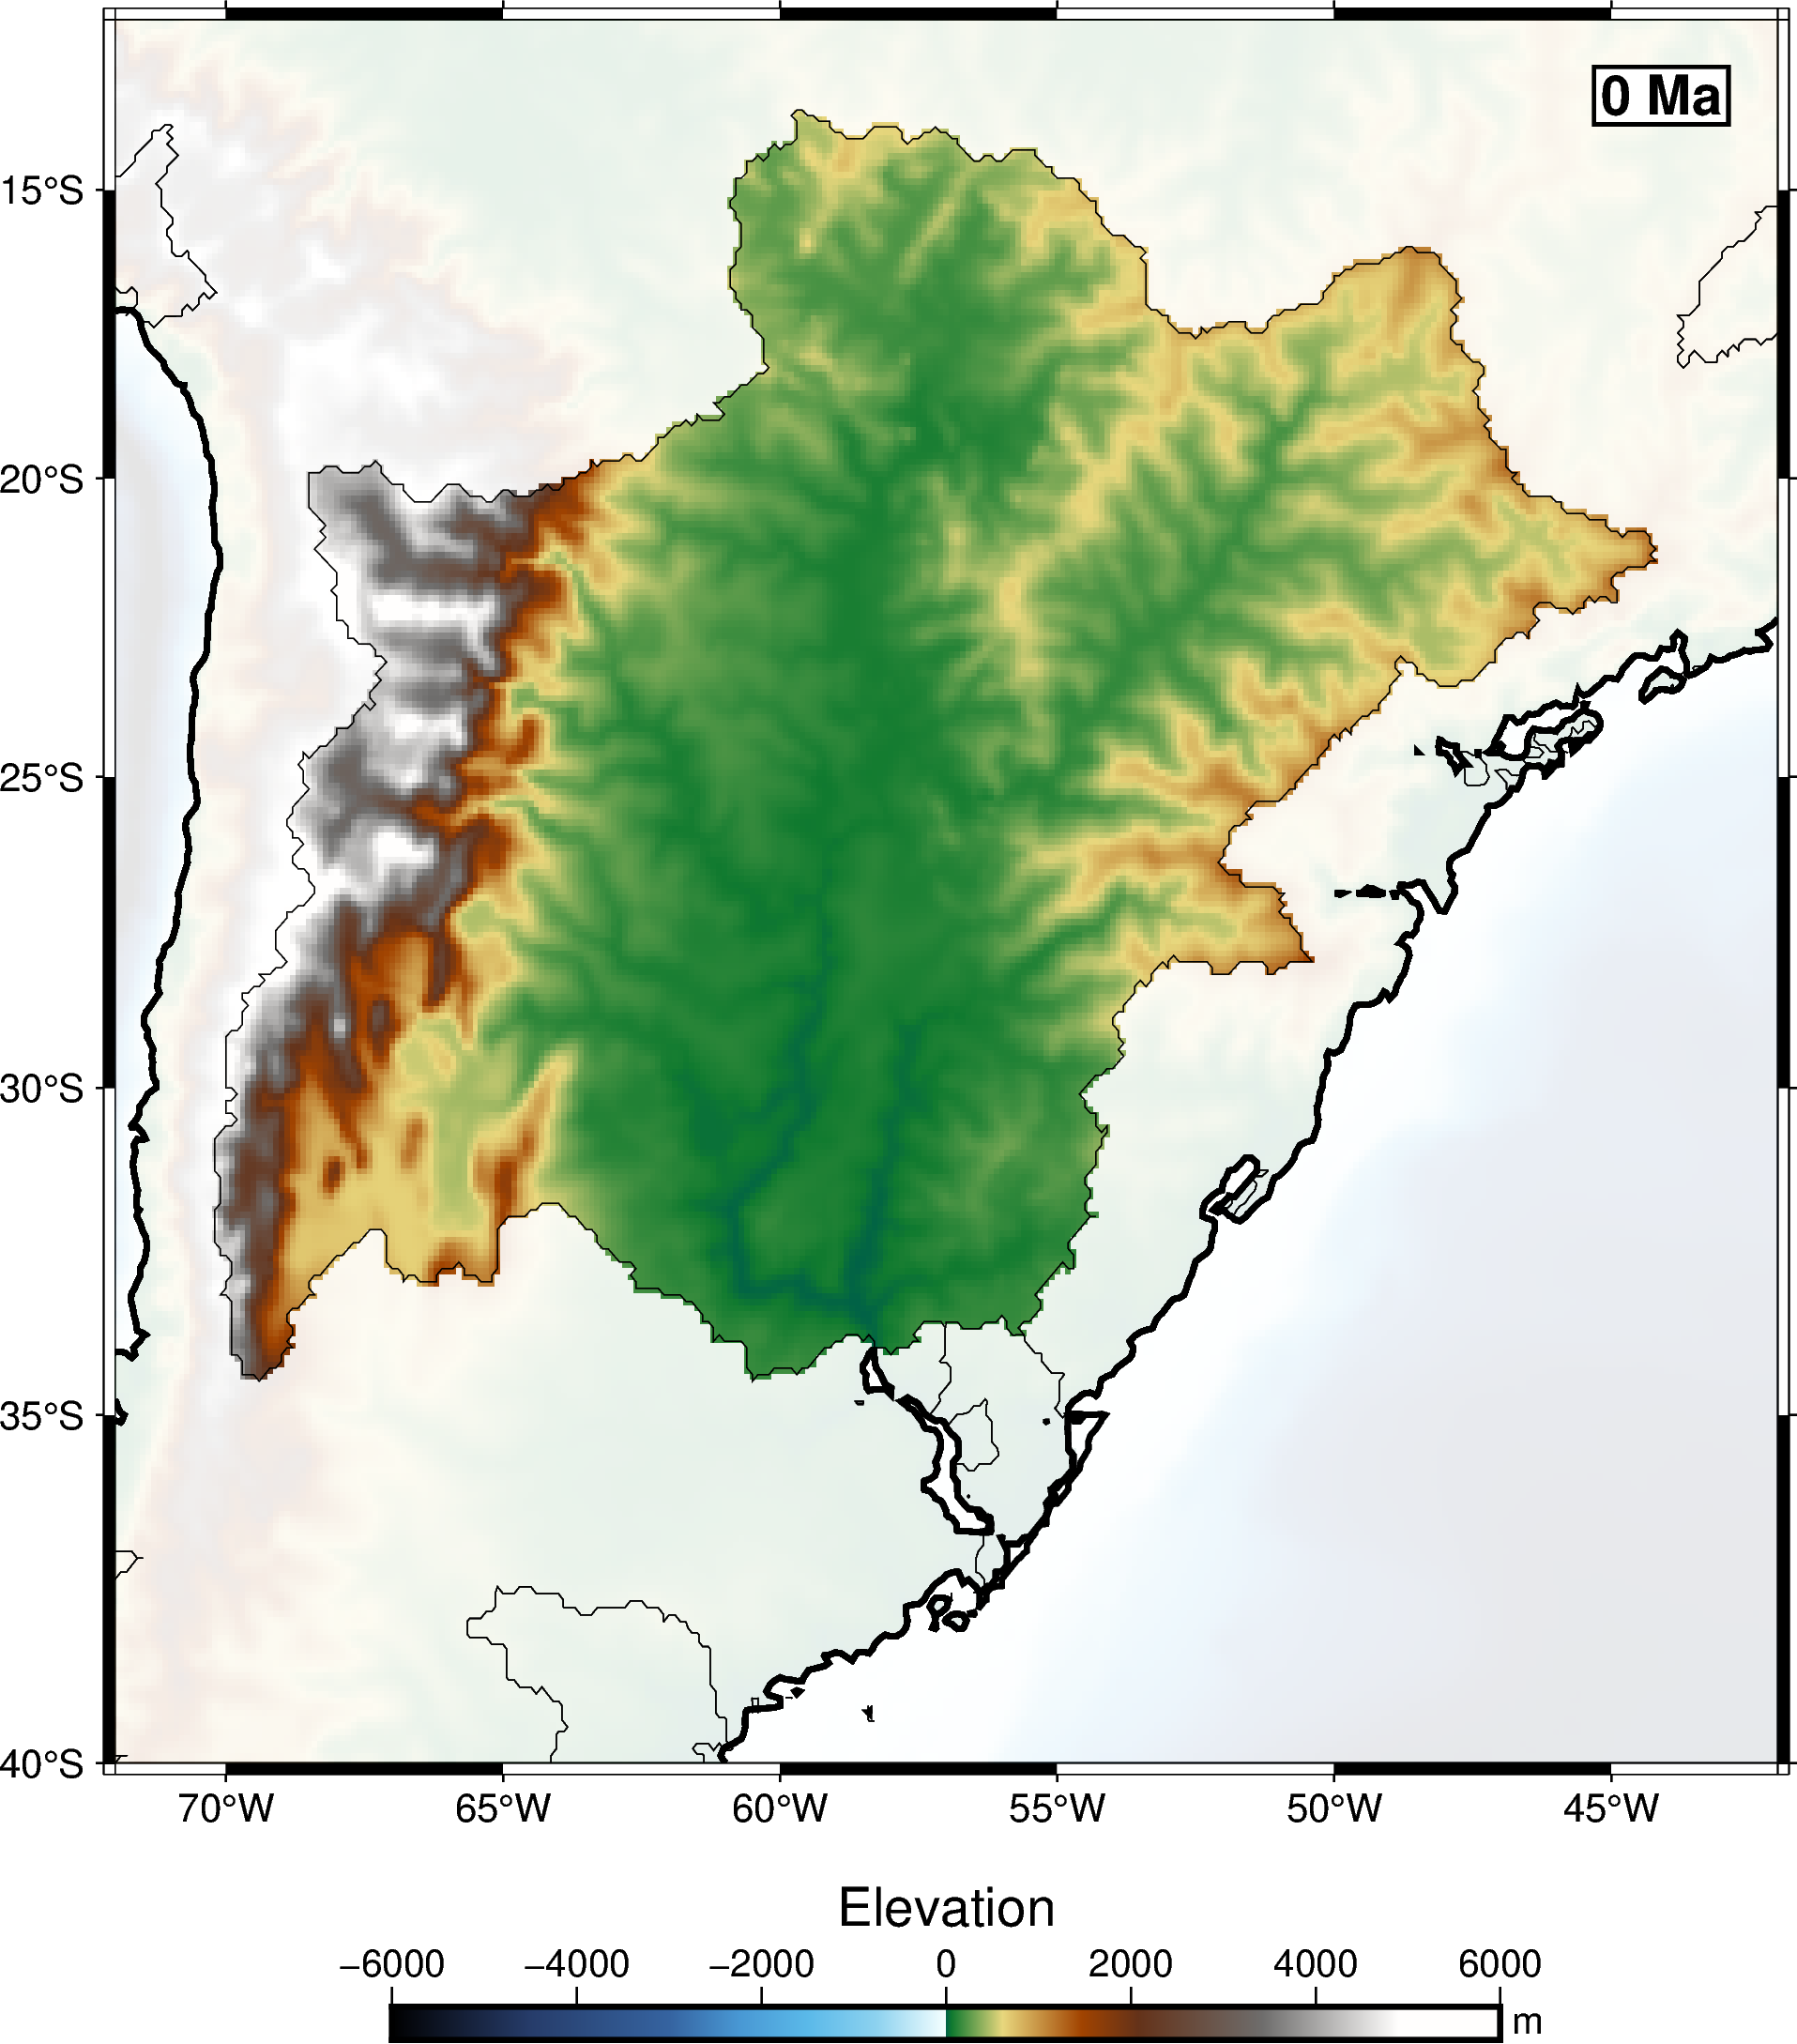

In [15]:
fig = pygmt.Figure()

proj='M15c'

# Plotting elevation
with pygmt.config(FONT='10p,Helvetica,black'):
    
    pygmt.makecpt(cmap="geo", series=[-6000, 6000])
    
    fig.basemap(region=region, projection='M15c', frame='a')
    
    fig.grdimage(clipds.elevation, 
                 shading=False, 
                 frame=False,
                 nan_transparent=True,
                 transparency=90,
                )
    
    fig.grdimage(clipds2.elevation, 
                 shading=False, 
                 frame=False,
                 nan_transparent=True,
                 transparency=0,
                )
    
    # Add contour
    fig.grdcontour(
        interval=0.1,
        grid=clipds.elevation,
        limit=[-0.1, 0.1],
        pen='1.5p'
    )

fig.colorbar(frame=["a2000", "x+lElevation", "y+lm"], position="jBC+o0c/-2.5c+w10c/0.3c+h") #position="JMR+o0.5c/0c+w8c")

# At time step
fig.text(text=str(step)+" Ma", position="TR", 
         fill='white', pen='1p', offset='-0.5',
         font="14p,Helvetica-Bold,black",)

# Add contour
fig.grdcontour(
    interval=1,
    grid=clipds.newBasin,
    region=region,
    projection=proj,
    limit=[582, 583],
    pen = '0.25p'
)


# name = 'celev'+str(step)+'Ma.png'
# fig.savefig(fname=name,dpi=500)

fig.show()#dpi=500, width=500)

#### Erosion deposition

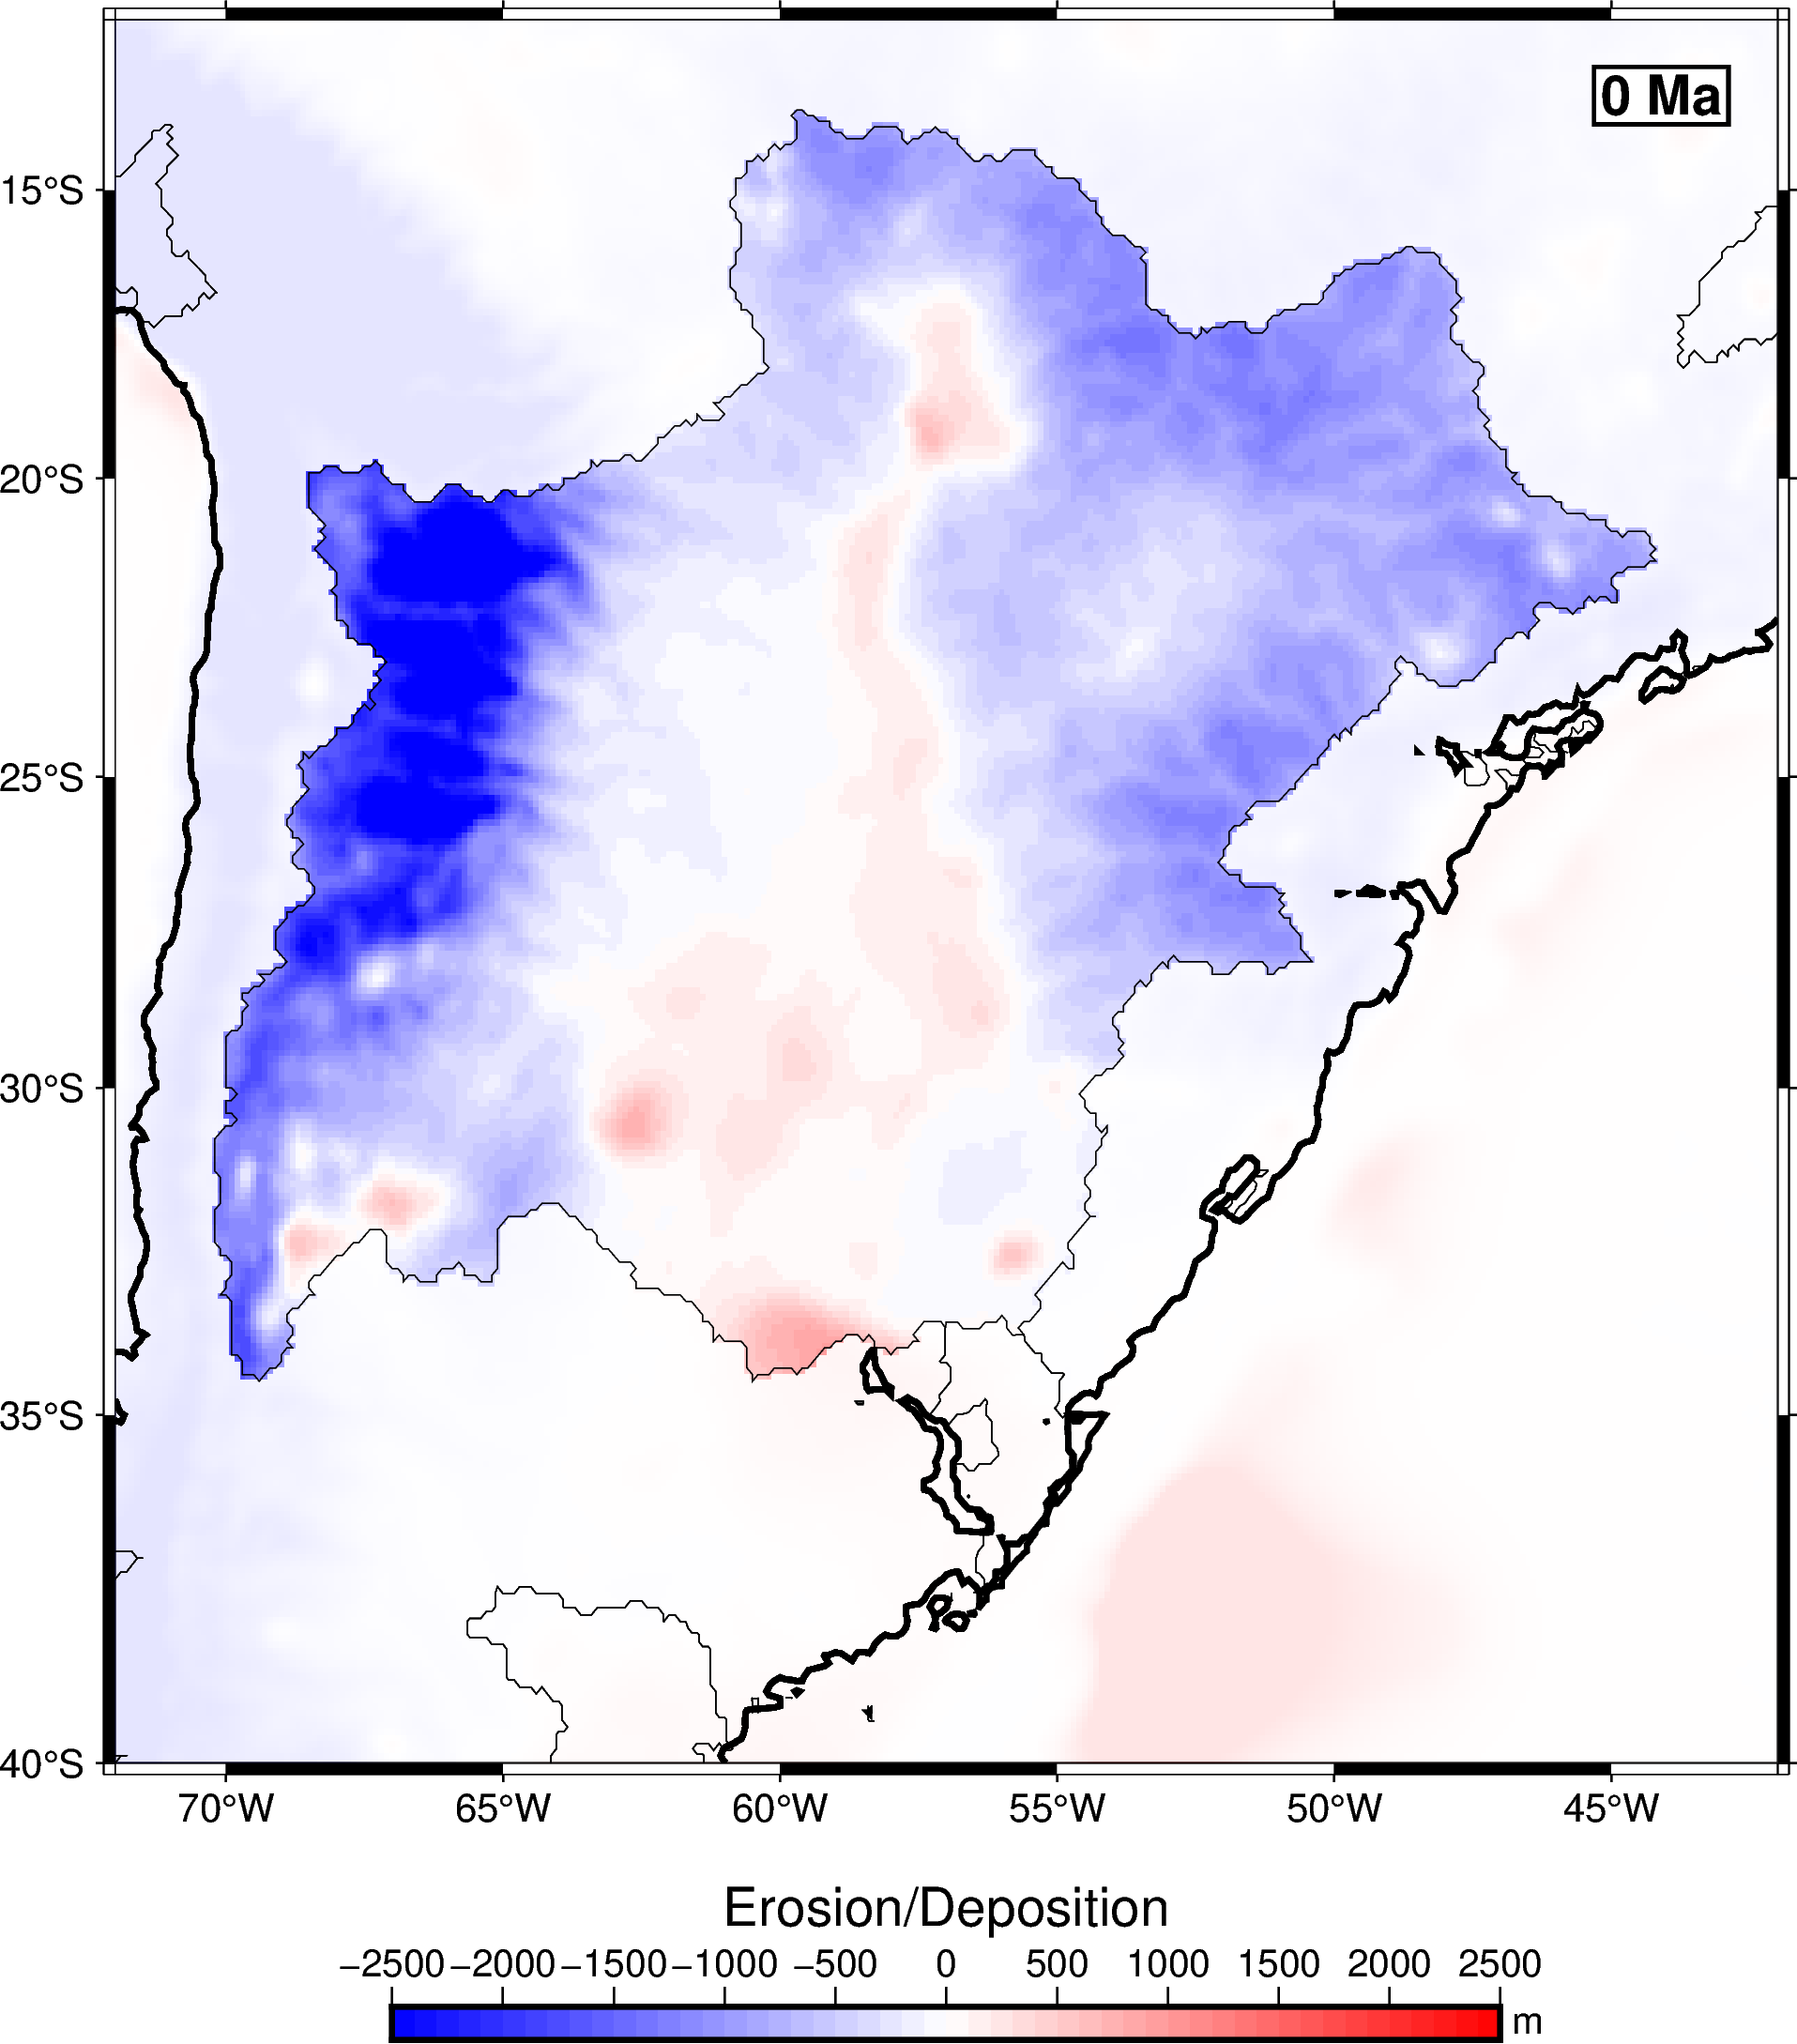

In [16]:
fig = pygmt.Figure()

proj='M15c'

# Plotting erosion deposition
with pygmt.config(FONT='10p,Helvetica,black'):
    
    with pygmt.config(COLOR_FOREGROUND="red", COLOR_BACKGROUND="blue"):
        pygmt.makecpt(
            cmap="polar", 
            series=[-2500,2500, 100],
        )
    
    fig.basemap(region=region, projection='M15c', frame='a')
    
    fig.grdimage(clipds.erodep, 
                 shading=False, 
                 frame=False,
                 nan_transparent=True,
                 transparency=90,
                )
    
    fig.grdimage(clipds2.erodep, 
                 shading=False, 
                 frame=False,
                 nan_transparent=True,
                 transparency=0,
                )
    
    # Add contour
    fig.grdcontour(
        interval=0.1,
        grid=clipds.elevation,
        limit=[-0.1, 0.1],
        pen='1.5p'
    )

fig.colorbar(frame=["a500", "x+lErosion/Deposition", "y+lm"], position="jBC+o0c/-2.5c+w10c/0.3c+h") #JMR+o0.5c/0c+w8c")


# At time step
fig.text(text=str(step)+" Ma", position="TR", 
         fill='white', pen='1p', offset='-0.5',
         font="14p,Helvetica-Bold,black",)

# Add contour
fig.grdcontour(
    interval=1,
    grid=clipds.newBasin,
    region=region,
    projection=proj,
    limit=[582, 583],
    pen = '0.25p'
)


# name = 'cerodep'+str(step)+'Ma.png'
# fig.savefig(fname=name,dpi=500)

fig.show()#dpi=500, width=500)

#### Flow discharge

In [17]:
vals = np.log10(clipds2.fillDischarge)
vals.max()

<xarray.DataArray 'fillDischarge' ()>
array(13.01350672)

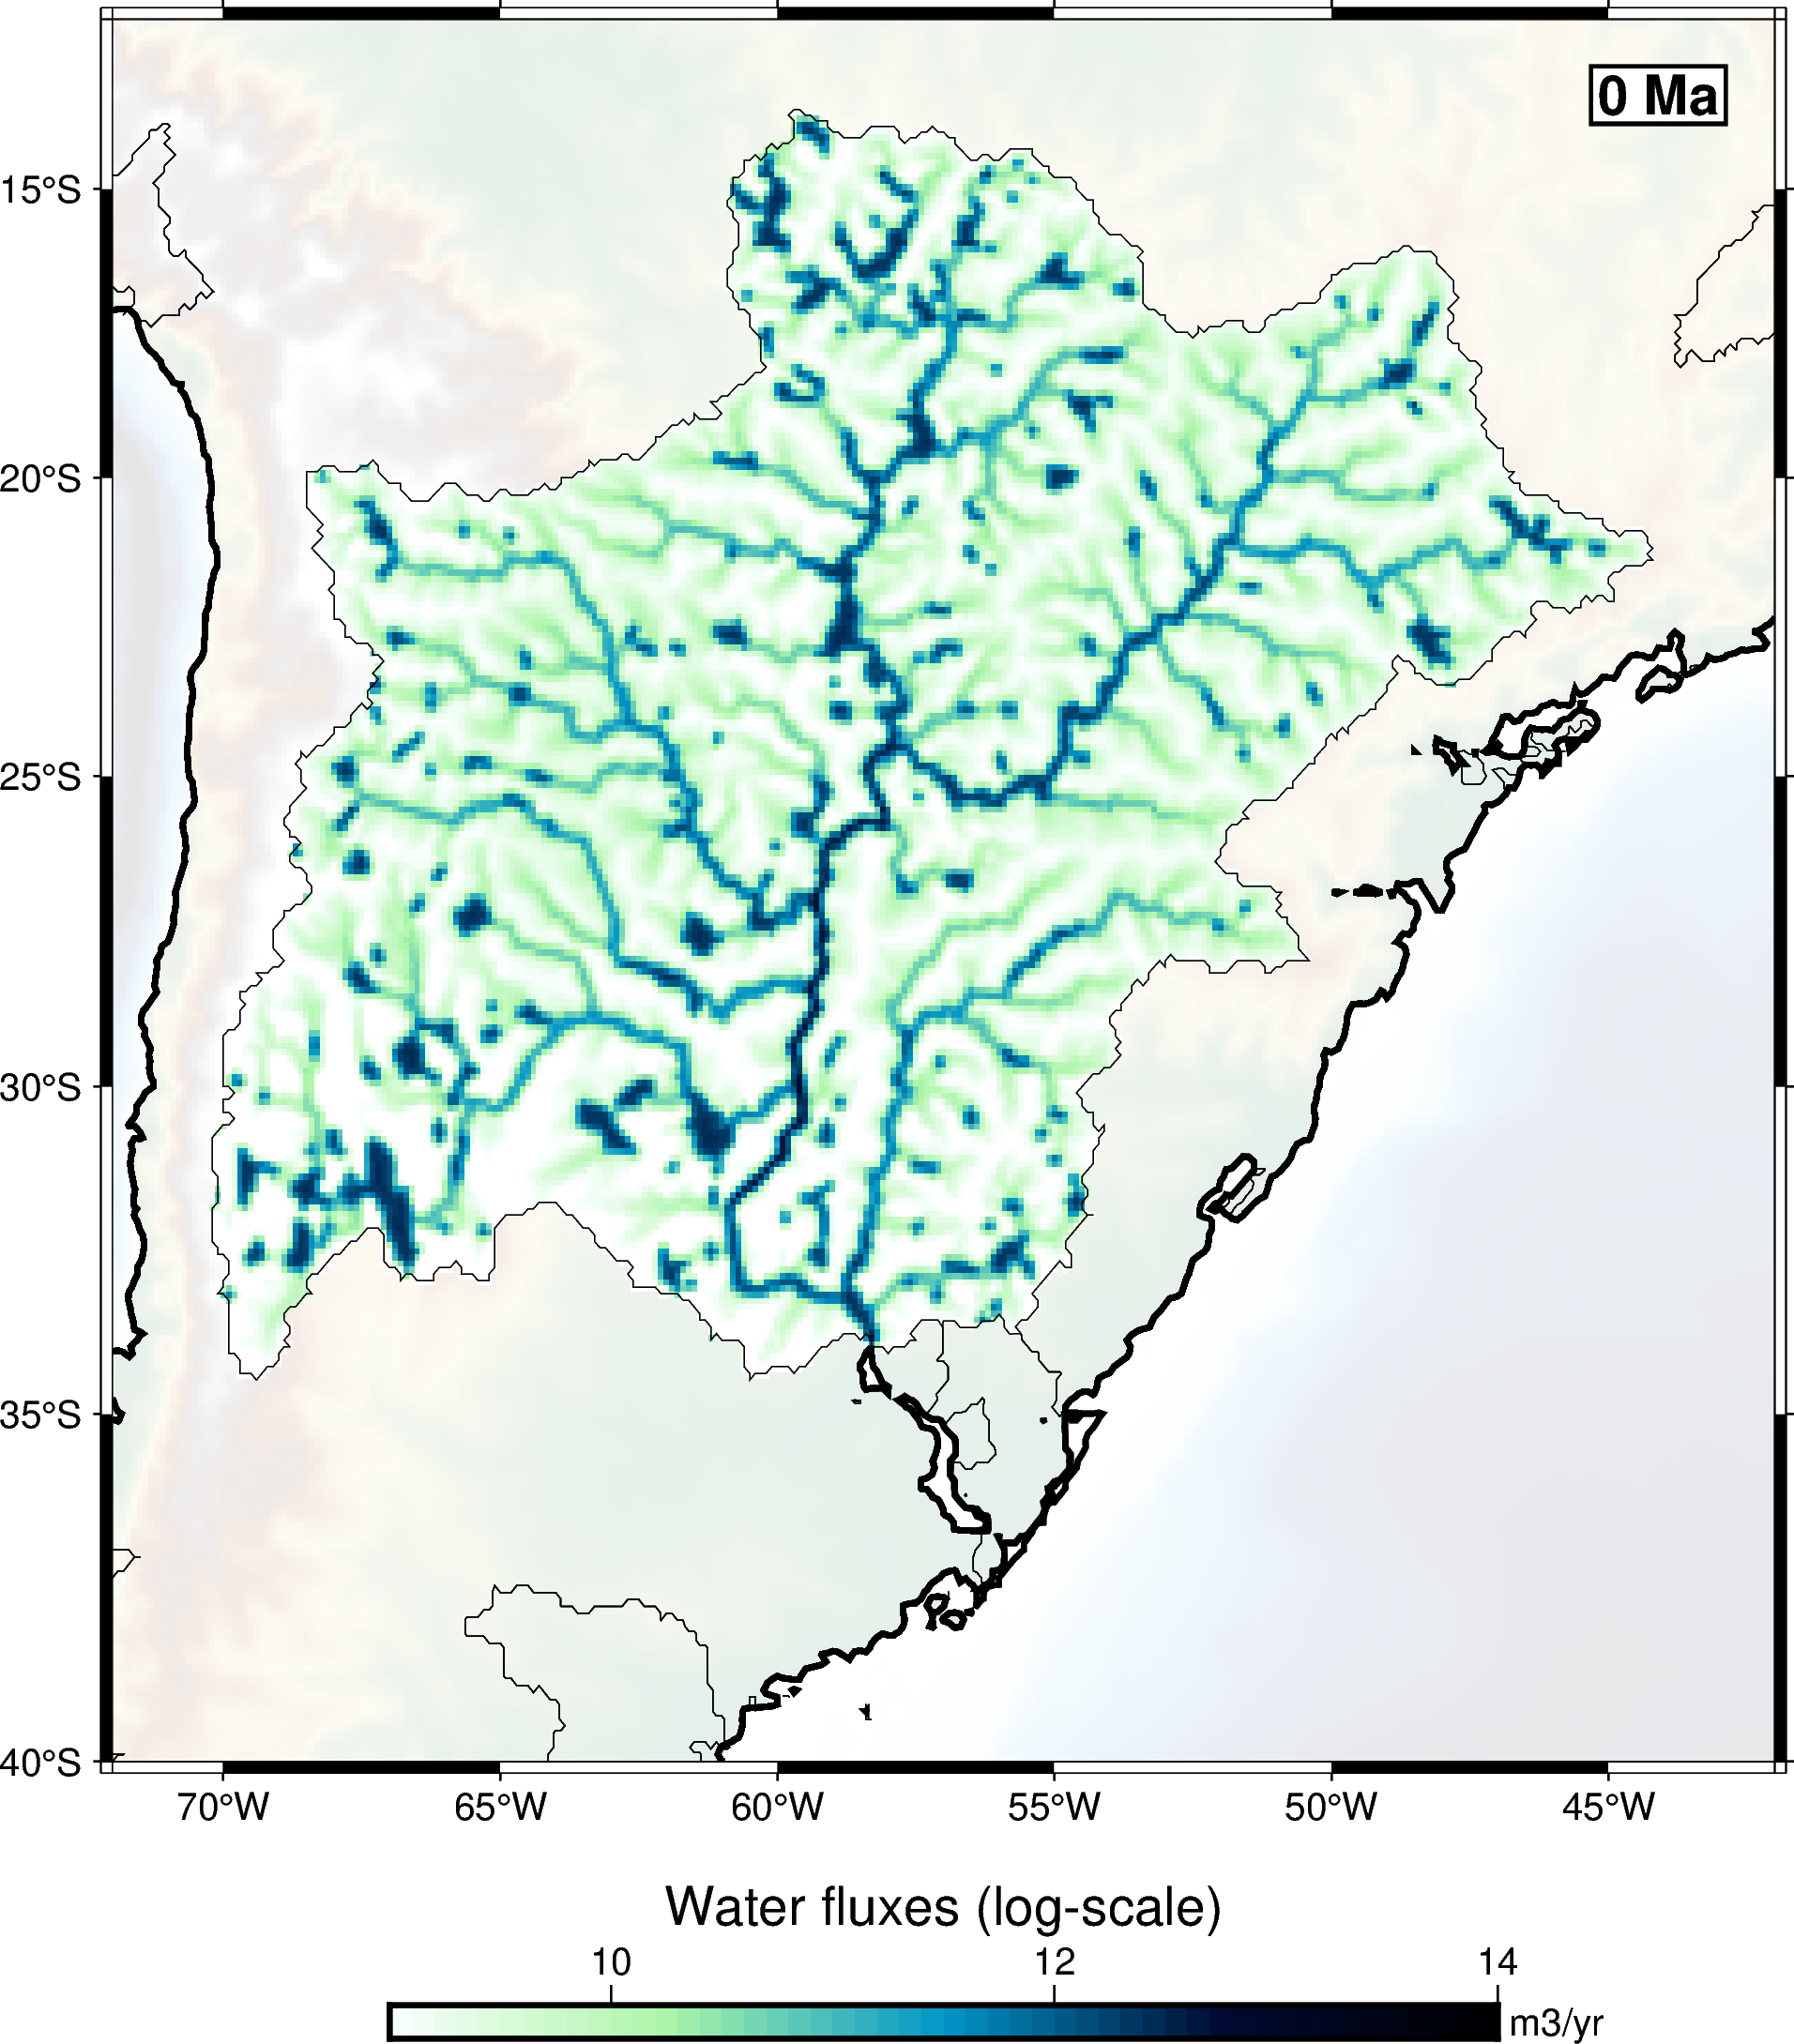

In [18]:
# Plotting log of flow discharge
with pygmt.config(FONT='10p,Helvetica,black'):
    
    
    fig = pygmt.Figure()

    pygmt.makecpt(cmap="geo", series=[-6000, 6000])
    
    fig.basemap(region=region, projection='M15c', frame='a')
    
    fig.grdimage(clipds.elevation, 
                 shading=False, 
                 frame=False,
                 nan_transparent=True,
                 transparency=90,
                )

    with pygmt.config(COLOR_BACKGROUND="white"):
            pygmt.makecpt(
            cmap="ocean", 
            series=[9,14,0.1],
            reverse=True,
        )
    
    fig.grdimage(vals, 
                 shading=False, 
                 frame=False,
                 nan_transparent=True,
                 transparency=0,
                )

# Add contour
fig.grdcontour(
    interval=0.1,
    grid=clipds.elevation,
    limit=[-0.1, 0.1],
    pen = '1.5p'
)

# Add contour
fig.grdcontour(
    interval=1,
    grid=clipds.newBasin,
    limit=[582, 583],
    pen = '0.25p'
)

fig.colorbar(frame=["a2", 'x+l"Water fluxes (log-scale)"', "y+lm3/yr"], position="jBC+o0c/-2.5c+w10c/0.3c+h") #JMR+o0.5c/0c+w8c")

# At time step
fig.text(text=str(step)+" Ma", position="TR", 
         fill='white', pen='1p', offset='-0.5',
         font="14p,Helvetica-Bold,black",)

# name = 'cfa'+str(step)+'Ma.png'
# fig.savefig(fname=name,dpi=500)

fig.show()

## 3D views

#### Elevation

grdview [WARNING]: 15 annotations along the bottom border were skipped due to crowding.
grdview [WARNING]: 14 annotations along the right border were skipped due to crowding.
grdview [WARNING]: Crowding decisions is controlled by MAP_ANNOT_MIN_SPACING, currently set to 27.2009p.
grdview [WARNING]: Decrease or increase MAP_ANNOT_MIN_SPACING to see more or fewer annotations, with 0 showing all annotations.
grdview [WARNING]: 15 annotations along the bottom border were skipped due to crowding.
grdview [WARNING]: 14 annotations along the right border were skipped due to crowding.
grdview [WARNING]: Crowding decisions is controlled by MAP_ANNOT_MIN_SPACING, currently set to 27.2009p.
grdview [WARNING]: Decrease or increase MAP_ANNOT_MIN_SPACING to see more or fewer annotations, with 0 showing all annotations.


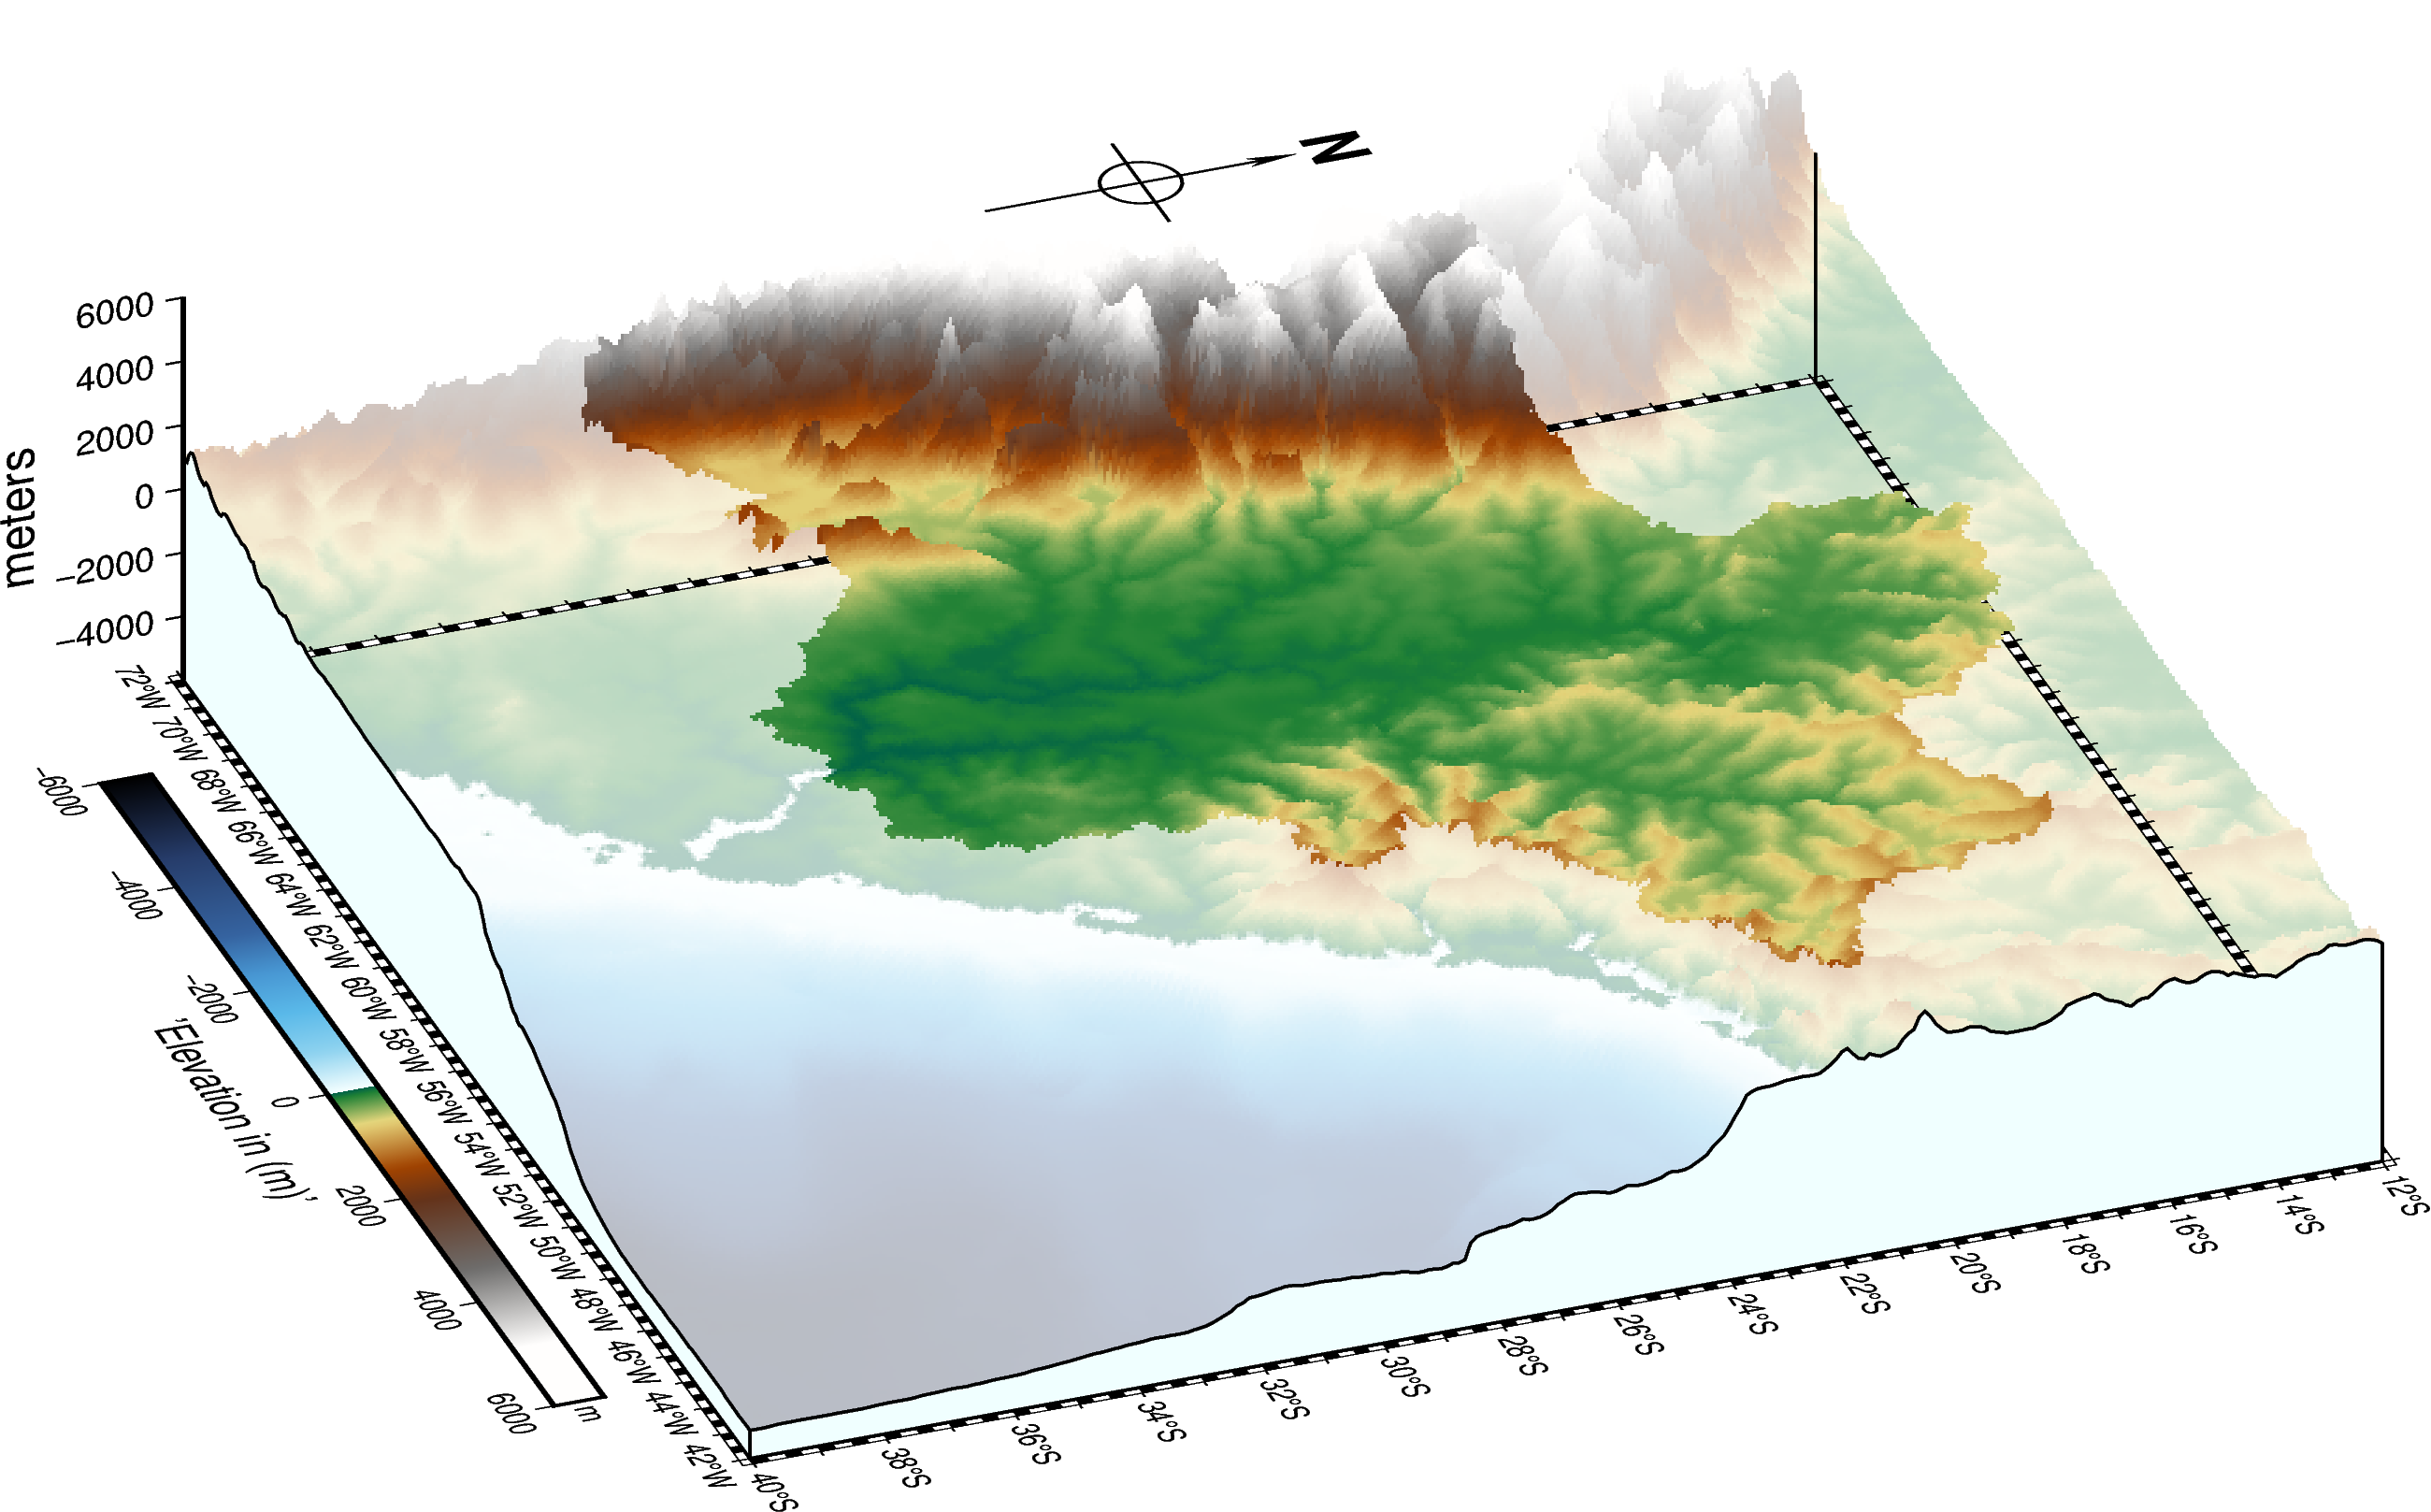

In [19]:
minlon, maxlon = -72., -42.
minlat, maxlat = -40, -12.

frame =  ["xa1f0.25","ya1f0.25", "z2000+lmeters", "wSEnZ"]

fig = pygmt.Figure()

pygmt.makecpt(
        cmap='geo',
        series=f'-6000/6000/100',
        continuous=True
    )

fig.grdview(
    grid=clipds.elevation,
    region=[minlon, maxlon, minlat, maxlat, -6000, 6000],
    perspective=[110, 30],
    frame=frame,
    projection="M15c",
    zsize="4c",
    surftype="i",
    plane="-6000+gazure",
    shading=0,
    # Set the contour pen thickness to "1p"
    contourpen="1p",
    transparency="70"
)

fig.grdview(
    grid=clipds.elevation,
    drapegrid=clipds2.elevation,
    region=[minlon, maxlon, minlat, maxlat, -6000, 6000],
    perspective=[110, 30],
    frame=frame,
    projection="M15c",
    zsize="4c",
    surftype="c",
    plane="-6000+gazure",
    shading=0,
    # Set the contour pen thickness to "1p"
    contourpen="1p",
)

fig.basemap(
    perspective=True,
    rose="jTL+w3c+l+o-7c/3c" #map directional rose at the top left corner 
)

fig.colorbar(perspective=True, frame=["a2000", "x+l'Elevation in (m)'", "y+lm"])
# fig.savefig("topo-plot_3d.png", crop=True, dpi=300)
fig.show(width=1000)

#### Erosion deposition

grdview [WARNING]: 15 annotations along the bottom border were skipped due to crowding.
grdview [WARNING]: 14 annotations along the right border were skipped due to crowding.
grdview [WARNING]: Crowding decisions is controlled by MAP_ANNOT_MIN_SPACING, currently set to 27.2009p.
grdview [WARNING]: Decrease or increase MAP_ANNOT_MIN_SPACING to see more or fewer annotations, with 0 showing all annotations.
grdview [WARNING]: 15 annotations along the bottom border were skipped due to crowding.
grdview [WARNING]: 14 annotations along the right border were skipped due to crowding.
grdview [WARNING]: Crowding decisions is controlled by MAP_ANNOT_MIN_SPACING, currently set to 27.2009p.
grdview [WARNING]: Decrease or increase MAP_ANNOT_MIN_SPACING to see more or fewer annotations, with 0 showing all annotations.


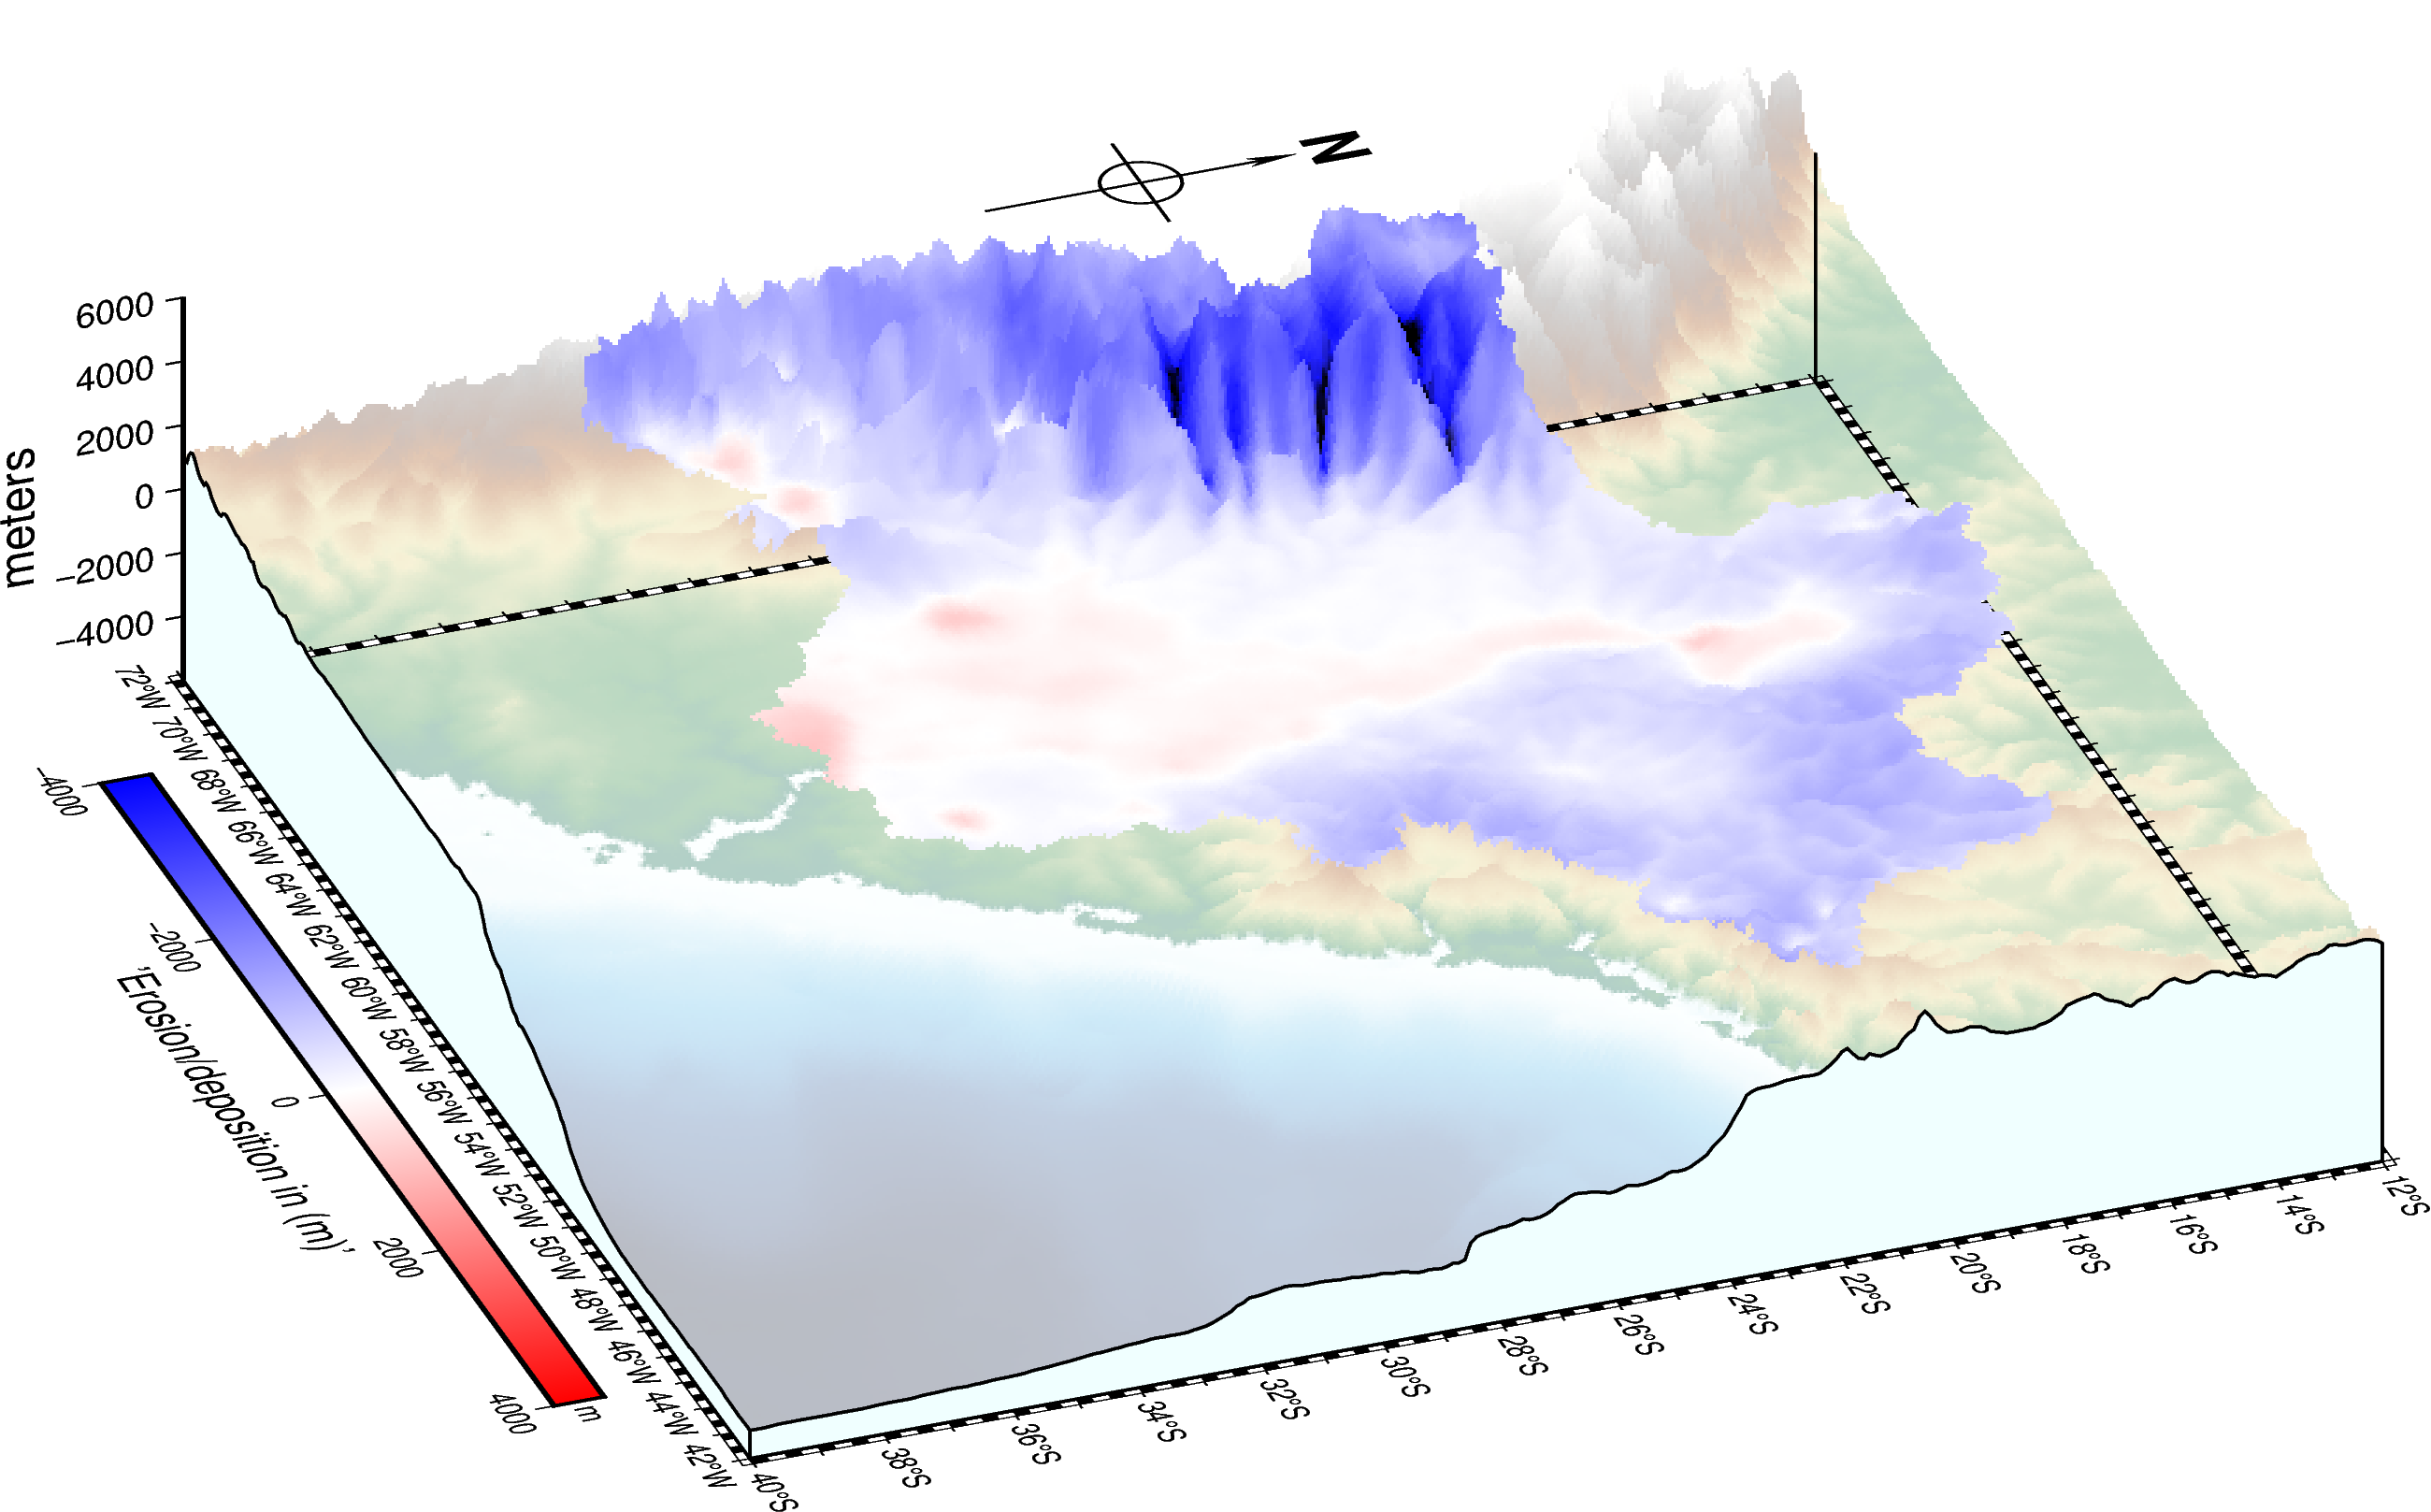

In [20]:
minlon, maxlon = -72., -42.
minlat, maxlat = -40, -12.

frame =  ["xa1f0.25","ya1f0.25", "z2000+lmeters", "wSEnZ"]

fig = pygmt.Figure()


pygmt.makecpt(
        cmap='geo',
        series=f'-6000/6000/100',
        continuous=True
    )

fig.grdview(
    grid=clipds.elevation,
    region=[minlon, maxlon, minlat, maxlat, -6000, 6000],
    perspective=[110, 30],
    frame=frame,
    projection="M15c",
    zsize="4c",
    surftype="i",
    plane="-6000+gazure",
    shading=0,
    # Set the contour pen thickness to "1p"
    contourpen="1p",
    transparency="70"
)


pygmt.makecpt(
        cmap='polar',
        series=f'-4000/4000/100',
        continuous=True
    )

fig.grdview(
    grid=clipds.elevation,
    drapegrid=clipds2.erodep,
    region=[minlon, maxlon, minlat, maxlat, -6000, 6000],
    perspective=[110, 30],
    frame=frame,
    projection="M15c",
    zsize="4c",
    surftype="c",
    plane="-6000+gazure",
    shading=0,
    # Set the contour pen thickness to "1p"
    contourpen="1p",
)



fig.basemap(
    perspective=True,
    rose="jTL+w3c+l+o-7c/3c" #map directional rose at the top left corner 
)

fig.colorbar(perspective=True, frame=["a2000", "x+l'Erosion/deposition in (m)'", "y+lm"])
# fig.savefig("ed-plot_3d.png", crop=True, dpi=300)
fig.show(width=1000)